In [98]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
import itertools
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 16
import numpy as np
import pandas as pd
import requests
import seaborn as sns

import covid19

## data

In [116]:
deaths_path = 'time_series_covid19_deaths_US.csv'
deaths_path = covid19.data.download('deaths', repo='usa')
confirmed_path = 'time_series_covid19_deaths_US.csv'
confirmed_path = covid19.data.download('confirmed', repo='usa')
deaths_path, confirmed_path

('time_series_covid19_deaths_US.csv', 'time_series_covid19_confirmed_US.csv')

In [117]:
ds_counties = covid19.data.read_jhu_usa(deaths_path)
ds_counties['confirmed'] = covid19.data.read_jhu_usa(confirmed_path)['confirmed']
ds_counties['mortality'] = ds_counties['deaths'] / ds_counties['population'] * 1_000_000
ds_counties['daily_deaths'] = ds_counties['deaths'].diff('time')
ds_counties['daily_mortality'] = ds_counties['daily_deaths'] / ds_counties['population'] * 1_000_000
ds_counties['daily_mortality7'] = ds_counties['daily_mortality'].rolling({'time': 7}).mean()
ds_counties['daily_confirmed'] = ds_counties['confirmed'].diff('time')
ds_counties['daily_prevalence'] = ds_counties['daily_confirmed'] / ds_counties['population'] * 1_000_000
ds_counties['daily_prevalence7'] = ds_counties['daily_prevalence'].rolling({'time': 7}).mean()

ds_counties = ds_counties.fillna(0)
ds_counties

<xarray.Dataset>
Dimensions:            (location: 3340, time: 273)
Coordinates:
  * time               (time) datetime64[ns] 2020-01-22 ... 2020-10-20
    state_region       (location) <U29 'US / Alabama' ... 'US / Wyoming'
    country            (location) <U2 'US' 'US' 'US' 'US' ... 'US' 'US' 'US'
    lat                (location) float64 32.54 30.73 31.87 ... 0.0 43.9 43.84
    lon                (location) float64 -86.64 -87.72 -85.39 ... -107.7 -104.6
  * location           (location) <U57 'US / Alabama / Autauga' ... 'US / Wyoming / Weston'
Data variables:
    population         (location) int64 55869 223234 24686 22394 ... 0 7805 6927
    deaths             (time, location) int64 0 0 0 0 0 0 0 0 ... 1 2 1 2 0 7 0
    confirmed          (time, location) int64 0 0 0 0 0 0 ... 716 404 0 139 101
    mortality          (time, location) float64 0.0 0.0 0.0 ... 0.0 896.9 0.0
    daily_deaths       (time, location) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    daily_mortality    (time, location) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    daily_mortality7   (time, location) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    daily_confirmed    (time, location) float64 0.0 0.0 0.0 0.0 ... 0.0 4.0 2.0
    daily_prevalence   (time, location) float64 0.0 0.0 0.0 ... 0.0 512.5 288.7
    daily_prevalence7  (time, location) float64 0.0 0.0 0.0 ... 0.0 219.6 804.3

In [118]:
tmp = ds_counties.sortby(-ds_counties['daily_mortality7'].isel(time=-1)).isel(time=-1)
tmp.sel(location=tmp['population'] > 100_000).to_dataframe().head(20)

population  deaths  confirmed    mortality  \
location                                                                     
US / Texas / Potter                 117415      96       7342   817.612741   
US / Iowa / Woodbury                103107      92       6853   892.276955   
US / Kansas / Wyandotte             165429     158       7956   955.092517   
US / Alabama / Calhoun              113605      59       4127   519.343339   
US / Indiana / Vanderburgh          181451      60       5593   330.667784   
US / Kansas / Shawnee               176875      77       3277   435.335689   
US / North Carolina / Alamance      169509      72       4828   424.756208   
US / Missouri / Jasper              121328      68       4843   560.464196   
US / Indiana / LaPorte              109888      57       2155   518.709959   
US / Pennsylvania / Schuylkill      141359      75       1656   530.564025   
US / Arkansas / Sebastian           127827      90       4598   704.076604   
US / Indiana / Madison              129569      93       2295   717.764280   
US / North Carolina / Craven        102139      55       2170   538.481873   
US / Missouri / Franklin            103967      40       2379   384.737465   
US / Florida / Citrus               149657     131       3059   875.334933   
US / Alabama / Houston              105882      32       3646   302.223230   
US / Texas / Ector                  166223     114       5832   685.825668   
US / Kentucky / Daviess             101511      26       1822   256.129878   
US / Louisiana / Ouachita           153279     160       6819  1043.848146   
US / Arkansas / Washington          239187     141      10985   589.496921   

                                daily_deaths  daily_mortality  \
location                                                        
US / Texas / Potter                      4.0        34.067198   
US / Iowa / Woodbury                     4.0        38.794650   
US / Kansas / Wyandotte                 13.0        78.583562   
US / Alabama / Calhoun                   0.0         0.000000   
US / Indiana / Vanderburgh              10.0        55.111297   
US / Kansas / Shawnee                    4.0        22.614841   
US / North Carolina / Alamance           4.0        23.597567   
US / Missouri / Jasper                   1.0         8.242121   
US / Indiana / LaPorte                   0.0         0.000000   
US / Pennsylvania / Schuylkill           2.0        14.148374   
US / Arkansas / Sebastian                2.0        15.646147   
US / Indiana / Madison                   2.0        15.435791   
US / North Carolina / Craven             5.0        48.952898   
US / Missouri / Franklin                 0.0         0.000000   
US / Florida / Citrus                    0.0         0.000000   
US / Alabama / Houston                   0.0         0.000000   
US / Texas / Ector                       2.0        12.032029   
US / Kentucky / Daviess                  1.0         9.851149   
US / Louisiana / Ouachita                1.0         6.524051   
US / Arkansas / Washington               1.0         4.180829   

                                daily_mortality7  daily_confirmed  \
location                                                            
US / Texas / Potter                    18.250284            103.0   
US / Iowa / Woodbury                   15.240755             33.0   
US / Kansas / Wyandotte                13.816890             40.0   
US / Alabama / Calhoun                 12.574899             25.0   
US / Indiana / Vanderburgh             11.809564             63.0   
US / Kansas / Shawnee                  11.307420             25.0   
US / North Carolina / Alamance         10.956013             13.0   
US / Missouri / Jasper                 10.597012             31.0   
US / Indiana / LaPorte                 10.400200             25.0   
US / Pennsylvania / Schuylkill         10.105981             24.0   
US / Arkansas / Sebastian              10.058237        

In [119]:
ds_states = ds_counties.groupby('state_region').sum().rename({'state_region': 'location'})
ds_states['mortality'] = ds_states['deaths'] / ds_states['population'] * 1_000_000
ds_states['daily_mortality'] = ds_states['daily_deaths'] / ds_states['population'] * 1_000_000
ds_states['daily_mortality7'] = ds_states['daily_mortality'].rolling({'time': 7}).mean()
ds_states['daily_prevalence'] = ds_states['daily_confirmed'] / ds_states['population'] * 1_000_000
ds_states['daily_prevalence7'] = ds_states['daily_prevalence'].rolling({'time': 7}).mean()
tmp = ds_states.isel(time=-1).copy()
tmp = tmp.sortby(-tmp['daily_prevalence7'])
STATES = list(tmp.location.values)
tmp.to_dataframe().head(50)

time  population  deaths  confirmed  \
location                                                              
US / North Dakota         2020-10-20      762062     412      33666   
US / South Dakota         2020-10-20      884659     330      34457   
US / Montana              2020-10-20     1068778     252      24093   
US / Wisconsin            2020-10-20     5822434    1633     178482   
US / Guam                 2020-10-20      164229      66       3886   
US / Nebraska             2020-10-20     1934408     565      59409   
US / Idaho                2020-10-20     1787065     535      54663   
US / Utah                 2020-10-20     3205958     551      96643   
US / Wyoming              2020-10-20      578759      61       9526   
US / Iowa                 2020-10-20     3155070    1576     109202   
US / Missouri             2020-10-20     6626371    2625     161849   
US / Tennessee            2020-10-20     6829174    2952     233569   
US / Illinois             2020-10-20    12671821    9537     354457   
US / Arkansas             2020-10-20     3017804    1728     100441   
US / Oklahoma             2020-10-20     3956971    1191     109548   
US / New Mexico           2020-10-20     2096829     942      37896   
US / Minnesota            2020-10-20     5639632    2299     125531   
US / Indiana              2020-10-20     6732219    4008     150664   
US / Alaska               2020-10-20      731545      67      11391   
US / Kansas               2020-10-20     2913314     895      72179   
US / Mississippi          2020-10-20     2976149    3202     111322   
US / Kentucky             2020-10-20     4467673    1342      89544   
US / Rhode Island         2020-10-20     1059361    1164      28649   
US / Nevada               2020-10-20     3080156    1727      91499   
US / Alabama              2020-10-20     4903185    2805     174528   
US / North Carolina       2020-10-20    10488084    3992     248750   
US / Michigan             2020-10-20     9986857    7383     165994   
US / Colorado             2020-10-20     5758736    2182      87559   
US / South Carolina       2020-10-20     5148714    3696     165493   
US / Texas                2020-10-20    28995881   17558     862277   
US / Ohio                 2020-10-20    11689100    5083     185639   
US / West Virginia        2020-10-20     1792147     411      20520   
US / Puerto Rico          2020-10-20     3754939     769      58643   
US / Florida              2020-10-20    21477737   16105     760389   
US / Delaware             2020-10-20      973764     668      23325   
US / Georgia              2020-10-20    10617423    7674     342438   
US / Arizona              2020-10-20     7278717    5837     232937   
US / Louisiana            2020-10-20     4648794    5772     176681   
US / Pennsylvania         2020-10-20    12801989    8516     189970   
US / New Jersey           2020-10-20     8882190   16227     222193   
US / Virginia             2020-10-20     8535519    3482     167270   
US / Connecticut          2020-10-20     3565287    4559      64455   
US / Massachusetts        2020-10-20     6892503    9758     145464   
US / Maryland             2020-10-20     6045680    4050     136744   
US / Washington           2020-10-20     7614893    2282      99150   
US / California           2020-10-20    39512223   17055     883746   
US / Oregon               2020-10-20     4217737     633      40136   
US / District of Columbia 2020-10-20      705749     642      16445   
US / New York             2020-10-20    19453561   33366     486480   
US / Hawaii               2020-10-20     1415872     189      14156   

                             mortality  daily_deaths  daily_mortality  \
location                                                                
US / North Dakota           540.638426           4.0         5.248917   
US / South Dakota           373.025087           7.0         7.912653   
US / Montana                235.783296         

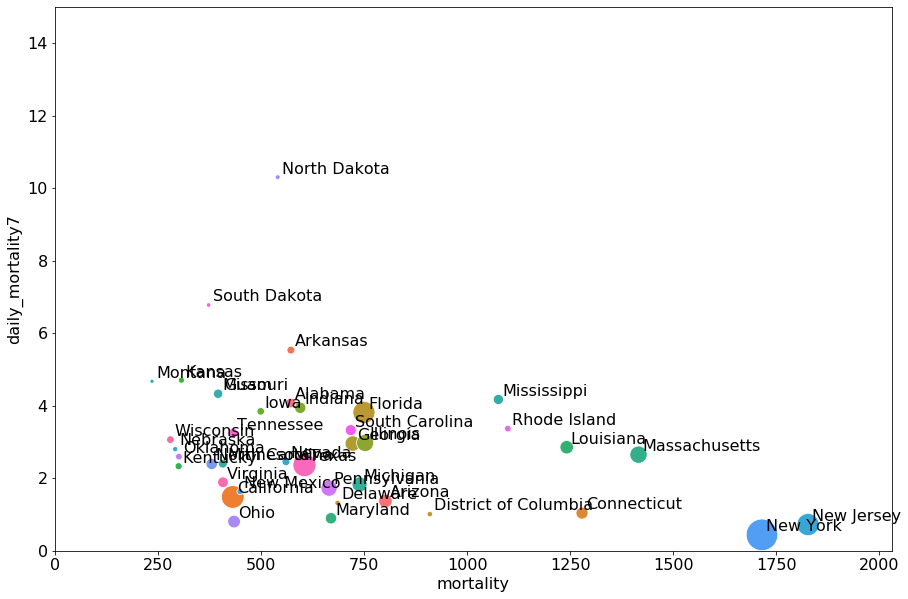

In [120]:
# sns.set()

world_hit = ds_states.sel(location=(((ds_states['daily_mortality7'].isel(time=-1) > 2.) | (ds_states['mortality'].isel(time=-1) > 400)) & (ds_states['deaths'] > 0)).any('time')).isel(time=slice(-100, None)).to_dataframe().reset_index()
# ax = sns.scatterplot(x="mortality", y="daily_mortality7", hue="location", size="deaths", data=world_hit, alpha=0.2, sizes=(10, 1_000), legend=False)
ax = sns.scatterplot(x="mortality", y="daily_mortality7", hue="location", size="deaths", data=world_hit[world_hit['time']==world_hit['time'].max()], sizes=(10, 1_000), legend=False)
_ = ax.set(ylim=(0, 15), xlim=(0, 2030))
for index in world_hit[world_hit['time']==world_hit['time'].max()].index:
    record = world_hit.loc[index]
    ax.annotate(record['location'].partition('US / ')[2], (record['mortality'] + 10, record['daily_mortality7'] + .1))

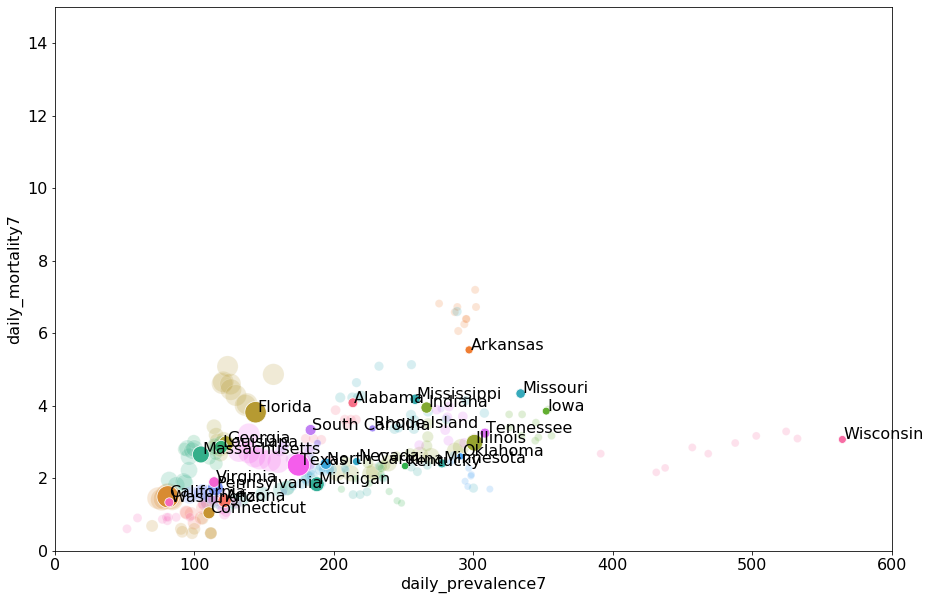

In [121]:
world_hit = ds_states.sel(location=(((ds_states['daily_mortality7'].isel(time=-1) > 1.) & (ds_states['mortality'] > 0).any('time')) & (ds_states['deaths'] > 1_000)).any('time')).isel(time=slice(-10, None)).to_dataframe().reset_index()
ax = sns.scatterplot(x="daily_prevalence7", y="daily_mortality7", hue="location", size="deaths", data=world_hit, alpha=0.2, sizes=(50, 500), legend=False)
ax = sns.scatterplot(x="daily_prevalence7", y="daily_mortality7", hue="location", size="deaths", data=world_hit[world_hit['time']==world_hit['time'].max()], sizes=(50, 500), legend=False)
_ = ax.set(ylim=(0, 15), xlim=(0, 600))
for index in world_hit[world_hit['time']==world_hit['time'].max()].index:
    record = world_hit.loc[index]
    if record['daily_mortality7'] > 15:
        continue
    ax.annotate(record['location'].partition('US / ')[2], (record['daily_prevalence7'] + 1, record['daily_mortality7'] + .01))

In [122]:
#### DAY = np.timedelta64(24 * 60 * 60, 's')
PALETTE_ONE = list(sns.color_palette())


EXTENT = ('2020-03-12', '2020-11-01')
XLIM = tuple(map(np.datetime64, EXTENT))

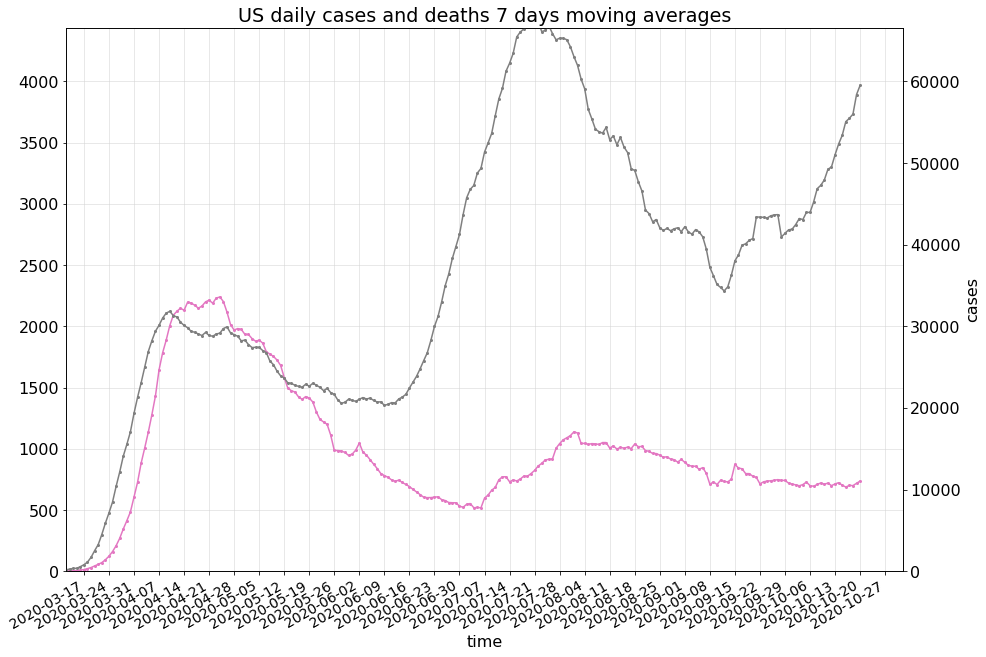

In [123]:
_, ax1 = covid19.plot.subplots(subplot_kw={'xlim': XLIM})
ax1.set(title=f'COVID-19 USA - Linear scale')
ax2 = ax1.twinx()

usa = ds_states.sum('location')

covid19.plot.plot_data(ax1, usa['daily_deaths'].rolling({'time': 7}).mean())
covid19.plot.plot_data(ax2, usa['daily_confirmed'].rolling({'time': 7}).mean())

ax1.set(ylim=(0, usa['population'] / 15 / 5_000), title='US daily cases and deaths 7 days moving averages') 
_ = ax2.set(ylim=(0, usa['population'] / 5_000), ylabel='cases') 


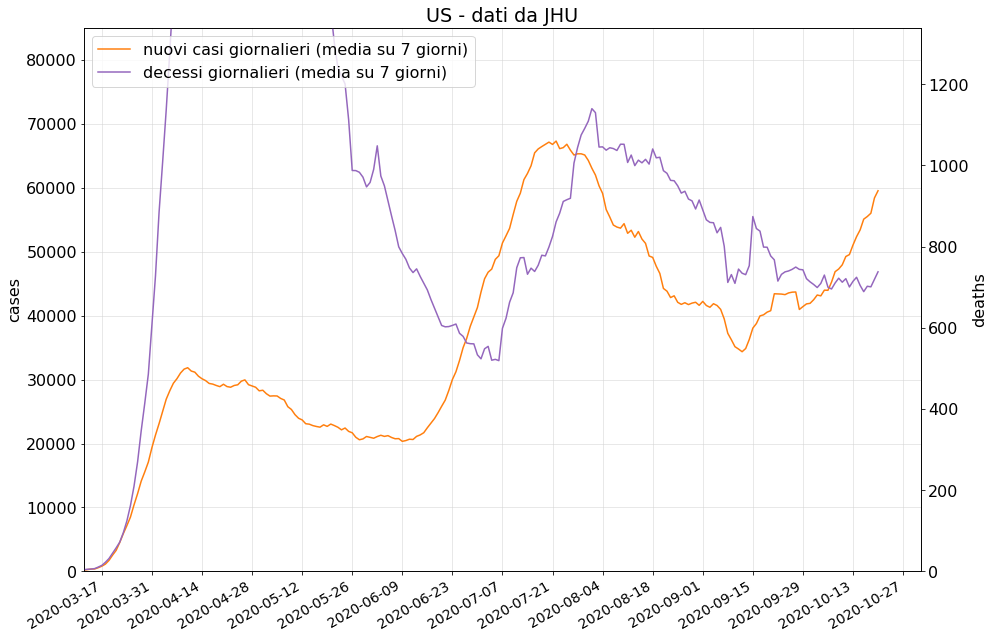

In [124]:
fig, ax1 = covid19.plot.subplots(subplot_kw={'xlim': tuple(map(np.datetime64, ('2020-03-12', '2020-11-01')))})
ax2 = ax1.twinx()

usa = ds_states.sum('location')

ax2.plot([0], [0], '-', color='tab:orange', label='nuovi casi giornalieri (media su 7 giorni)')
covid19.plot.plot_data(ax2, usa['daily_deaths'].rolling({'time': 7}).mean(), color='tab:purple', marker=None, label='decessi giornalieri (media su 7 giorni)')
covid19.plot.plot_data(ax1, usa['daily_confirmed'].rolling({'time': 7}).mean(), color='tab:orange', marker=None, date_interval=14)

ax2.set(ylim=(0, 85000. * 0.01575), title='US - dati da JHU', ylabel='deaths') 
ax1.yaxis.set_label_position("left")
ax2.legend(loc='upper left')
_ = ax1.set(ylim=(0, 85000.), ylabel='cases', xlabel='') 

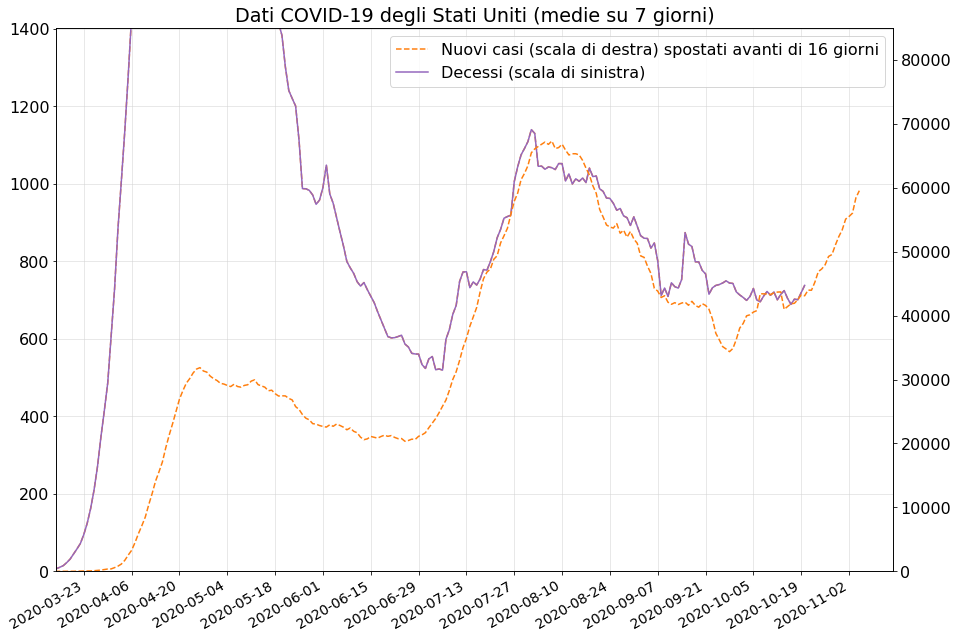

In [125]:
_, ax1 = covid19.plot.subplots(subplot_kw={'xlim': tuple(map(np.datetime64, ('2020-03-15', '2020-11-15')))})
ax2 = ax1.twinx()

usa = ds_states.sum('location')
usa['mortality'] = usa['deaths'] / usa['population'] * 1_000_000
usa['daily_mortality'] = usa['daily_deaths'] / usa['population'] * 1_000_000
usa['daily_mortality7'] = usa['daily_mortality'].rolling({'time': 7}).mean()
usa['daily_deaths7'] = usa['daily_deaths'].rolling({'time': 7}).mean()
usa['daily_prevalence'] = usa['daily_confirmed'] / usa['population'] * 1_000_000
usa['daily_prevalence7'] = usa['daily_prevalence'].rolling({'time': 7}).mean()
usa['daily_confirmed7'] = usa['daily_confirmed'].rolling({'time': 7}).mean()
usa['daily_confirmed14'] = usa['daily_confirmed'].rolling({'time': 14}).mean()


covid19.plot.plot_data(ax2, usa['daily_confirmed7'], delay=16, color='tab:orange', marker=None, linestyle='--')
covid19.plot.plot_data(ax1, usa['daily_deaths7'], label='Nuovi casi (scala di destra) spostati avanti di 16 giorni', color='tab:orange', marker=None, linestyle='--')
covid19.plot.plot_data(ax1, usa['daily_deaths7'], label='Decessi (scala di sinistra)', color='tab:purple', date_interval=14, marker=None)
# covid19.plot.plot_data(ax2, usa['daily_prevalence7'])
ax1.set(ylim=(0, 85000. * 0.0165), ylabel='', xlabel='') 
ax1.set(title=f'Dati COVID-19 degli Stati Uniti (medie su 7 giorni)', ylabel='')
_ = ax2.set(ylim=(0, 85000.), ylabel='', xlabel='') 
ax1.legend()

In [126]:
usa.to_dataframe().tail(20)

population  deaths  confirmed   mortality  daily_deaths  \
time                                                                  
2020-10-01   332865687  207790    7277791  624.245779         858.0   
2020-10-02   332865687  208697    7332297  626.970602         907.0   
2020-10-03   332865687  209384    7382341  629.034497         687.0   
2020-10-04   332865687  209721    7417845  630.046917         337.0   
2020-10-05   332865687  210181    7457402  631.428856         460.0   
2020-10-06   332865687  210886    7499341  633.546828         705.0   
2020-10-07   332865687  211801    7549682  636.295684         915.0   
2020-10-08   332865687  212762    7605873  639.182734         961.0   
2020-10-09   332865687  213752    7663293  642.156907         990.0   
2020-10-10   332865687  214370    7717932  644.013512         618.0   
2020-10-11   332865687  214768    7762546  645.209189         398.0   
2020-10-12   332865687  215085    7804199  646.161525         317.0   
2020-10-13   332865687  215887    7856605  648.570905         802.0   
2020-10-14   332865687  216872    7916099  651.530057         985.0   
2020-10-15   332865687  217692    7979709  653.993513         820.0   
2020-10-16   332865687  218575    8048865  656.646235         883.0   
2020-10-17   332865687  219286    8106384  658.782231         711.0   
2020-10-18   332865687  219674    8154594  659.947867         388.0   
2020-10-19   332865687  220119    8212981  661.284742         445.0   
2020-10-20   332865687  221052    8273296  664.087674         933.0   

            daily_mortality  daily_mortality7  daily_confirmed  \
time                                                             
2020-10-01         2.577616          2.142434          44749.0   
2020-10-02         2.724823          2.123121          54506.0   
2020-10-03         2.063896          2.100375          50044.0   
2020-10-04         1.012420          2.130847          35504.0   
2020-10-05         1.381939          2.192648          39557.0   
2020-10-06         2.117971          2.102950          41939.0   
2020-10-07         2.748856          2.089646          50341.0   
2020-10-08         2.887050          2.133851          56191.0   
2020-10-09         2.974173          2.169472          57420.0   
2020-10-10         1.856605          2.139859          54639.0   
2020-10-11         1.195677          2.166039          44614.0   
2020-10-12         0.952336          2.104667          41653.0   
2020-10-13         2.409380          2.146297          52406.0   
2020-10-14         2.959152          2.176339          59494.0   
2020-10-15         2.463456          2.115826          63610.0   
2020-10-16         2.652722          2.069904          69156.0   
2020-10-17         2.135997          2.109817          57519.0   
2020-10-18         1.165635          2.105525          48210.0   
2020-10-19         1.336876          2.160460          58387.0   
2020-10-20         2.802932          2.216681          60315.0   

            daily_prevalence  daily_prevalence7  daily_deaths7  \
time                                                             
2020-10-01        134.435605         125.938827     713.142857   
2020-10-02        163.747728         127.621617     706.714286   
2020-10-03        150.342922         129.841302     699.142857   
2020-10-04        106.661640         129.447321     709.285714   
2020-10-05        118.837722         132.127510     729.857143   
2020-10-06        125.993762         132.058413     700.000000   
2020-10-07        151.235174         135.893507     695.571429   
2020-10-08        168.809830         140.804111     710.285714   
2020-10-09        172.502010         142.054723     722.142857   
2020-10-10        164.147289         144.026775     712.285714   
2020-10-11        134.030036         147.936546     721.000000   
2020-10-12        125.134556         148.836094     700.571429   
2020-10-13        157.438877         153.328253     714.428571   
2020-1

In [111]:
STATES_FIT_PARAMS = {
    'US / New York': {
        'deaths': ['2020-03-22', '2020-04-04'],
    },
    'US / New Jersey': {
        'deaths': [None, '2020-04-05', '2020-04-05'],
    },
    'US / Connecticut': {
        'deaths': [None, '2020-04-08'],
    },
    'US / Massachusetts': {
        'deaths': [None, '2020-04-07'],
    },
    'US / Louisiana': {
        'deaths': [None, '2020-04-01'],
    },
    'US / District of Columbia': {
        'deaths': [None, '2020-04-01'],
    },
    'US / Michigan': {
        'deaths': ['2020-03-25', '2020-04-02', None],
    },
    'US / Rhode Island': {
        'deaths': [None, '2020-04-08'],
    },
    'US / Pennsylvania': {
        'deaths': [None, '2020-04-08'],
    },
    'US / Maryland': {
        'deaths': [None, None],
    },
    'US / Illinois': {
        'deaths': [None, '2020-04-10'],
    },
    'US / Indiana': {
        'deaths': [None, '2020-04-08'],
    },
    'US / Colorado': {
        'deaths': [None, None],
    },
    'US / Washington': {
        'deaths': [None, '2020-03-26', '2020-04-10'],
    },
    'US / Georgia': {
        'deaths': [None, '2020-04-10'],
    },
    'US / California': {
        'deaths': [None, '2020-03-26', None],
    },
    'US / Florida': {
        'deaths': [None, None],
    },
    'US / Delaware': {
        'deaths': [None, None],
    },
    'US / Nebraska': {
        'deaths': [None, None],
    },
}

In [112]:
region_fits = {}
for region, params in list(STATES_FIT_PARAMS.items()):
    region_fits[region] = {}
    for kind, breaks in params.items():
        ds = ds_states.sel(location=region)
        region_fits[region][kind] = covid19.fit.fit_exponential_segments(ds[kind], breaks)
        if 'daily_' + kind in ds:
            kinf = 'daily_' + kind 
            region_fits[region][kind] = covid19.fit.fit_exponential_segments(ds[kind], breaks)


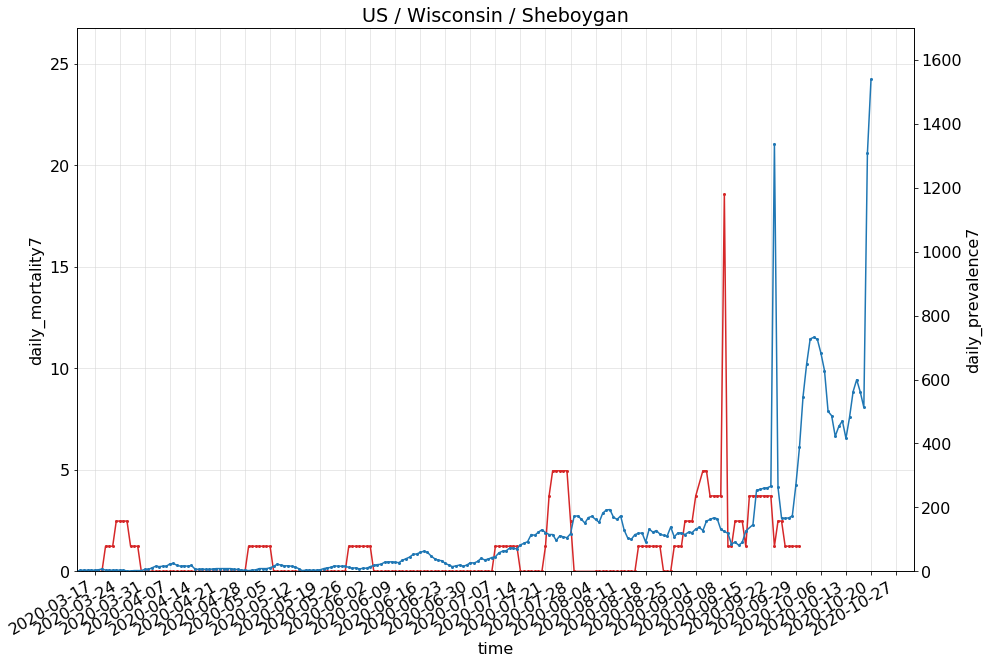

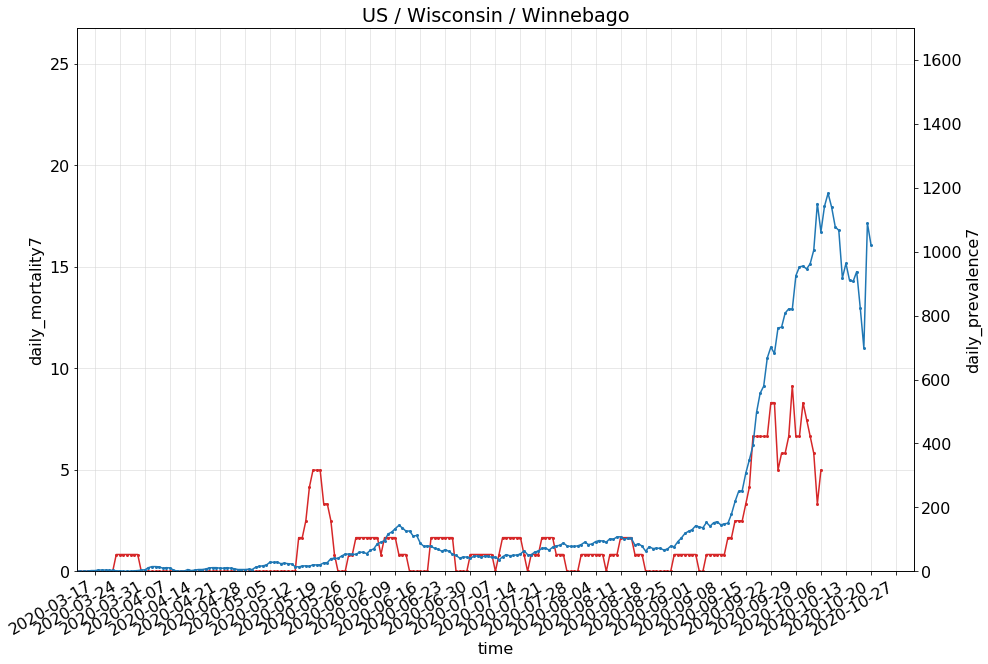

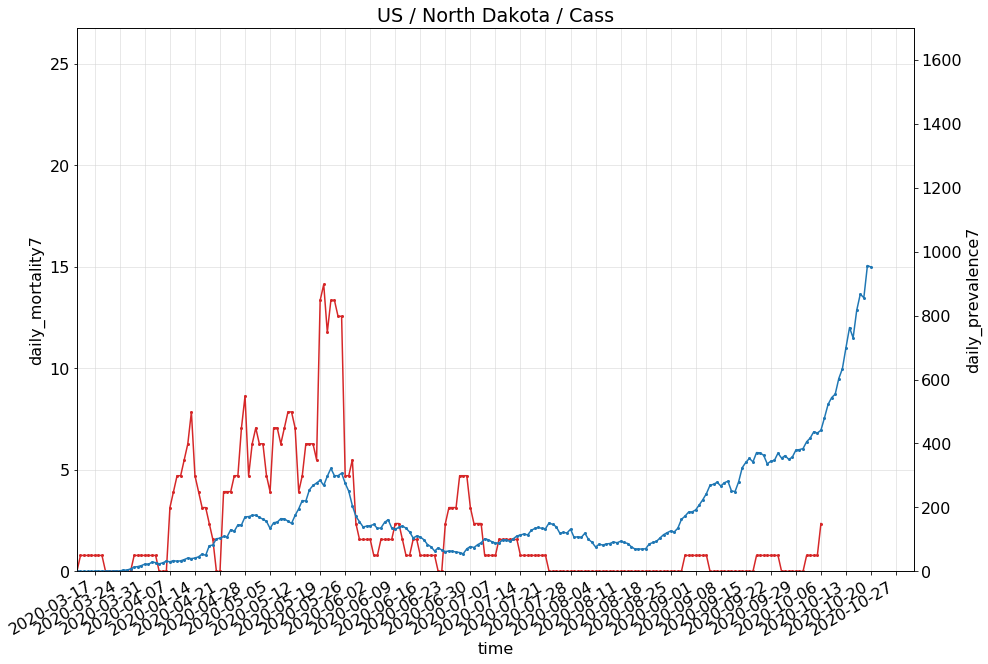

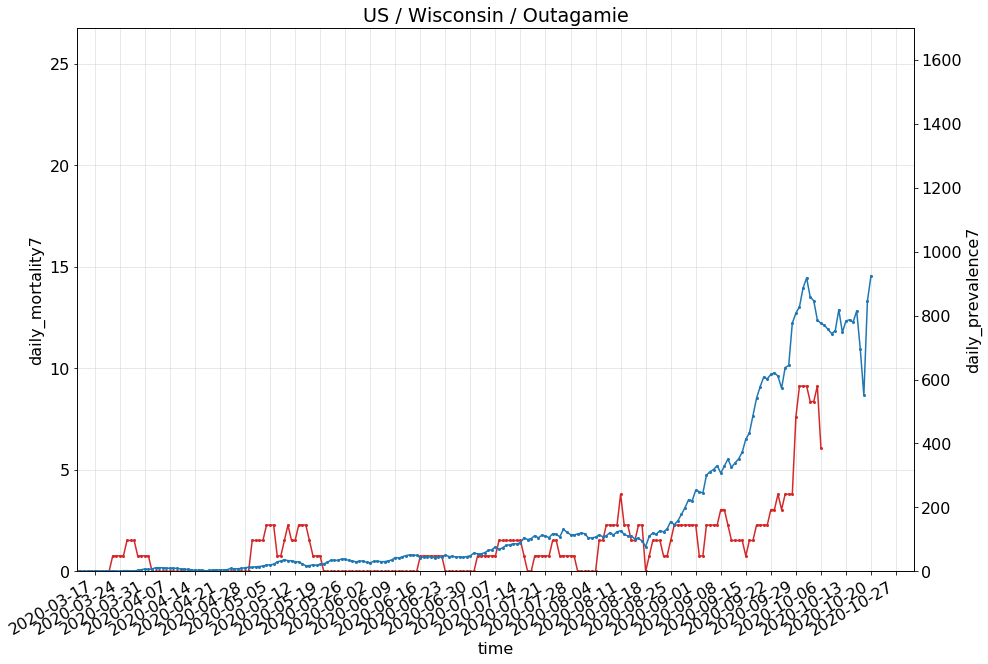

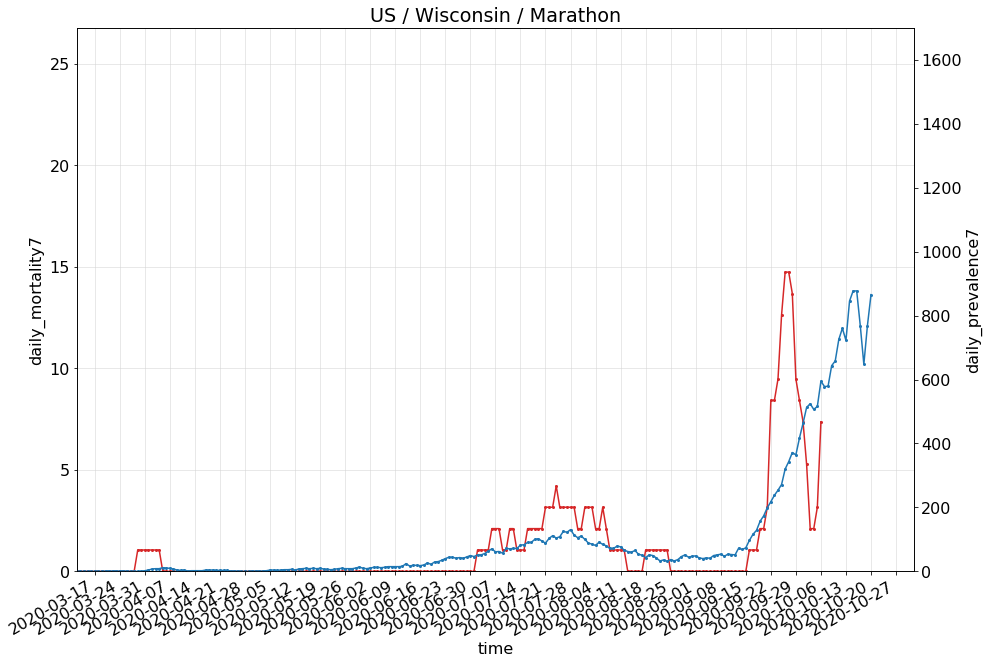

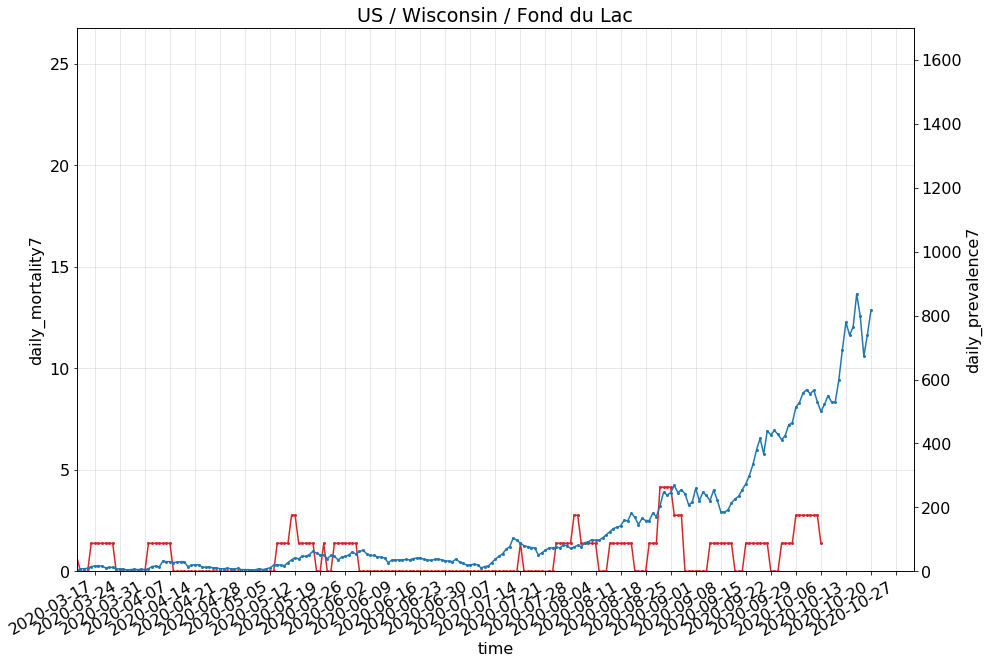

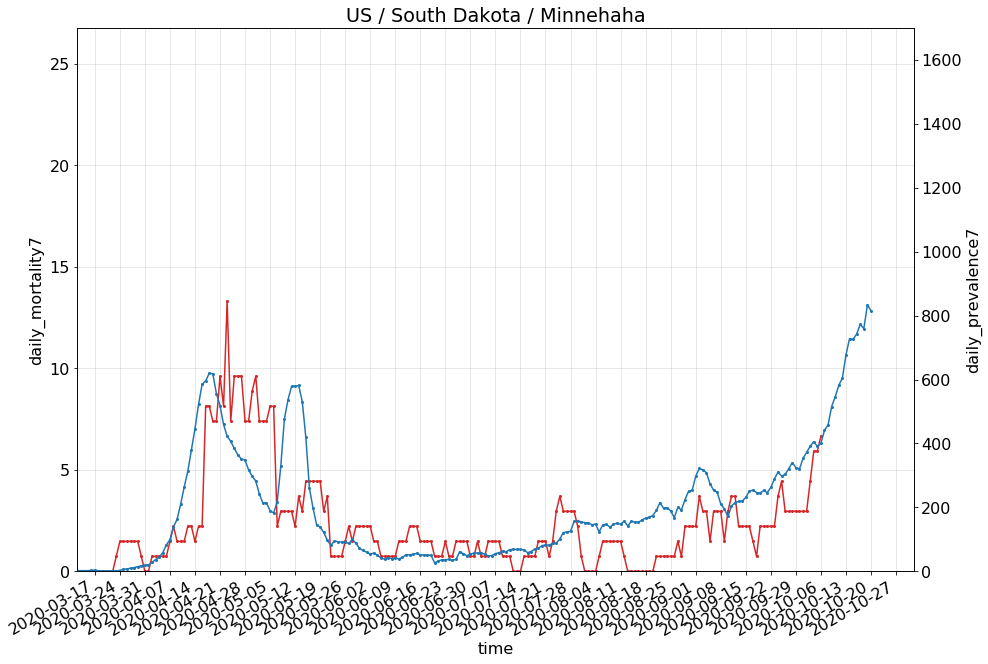

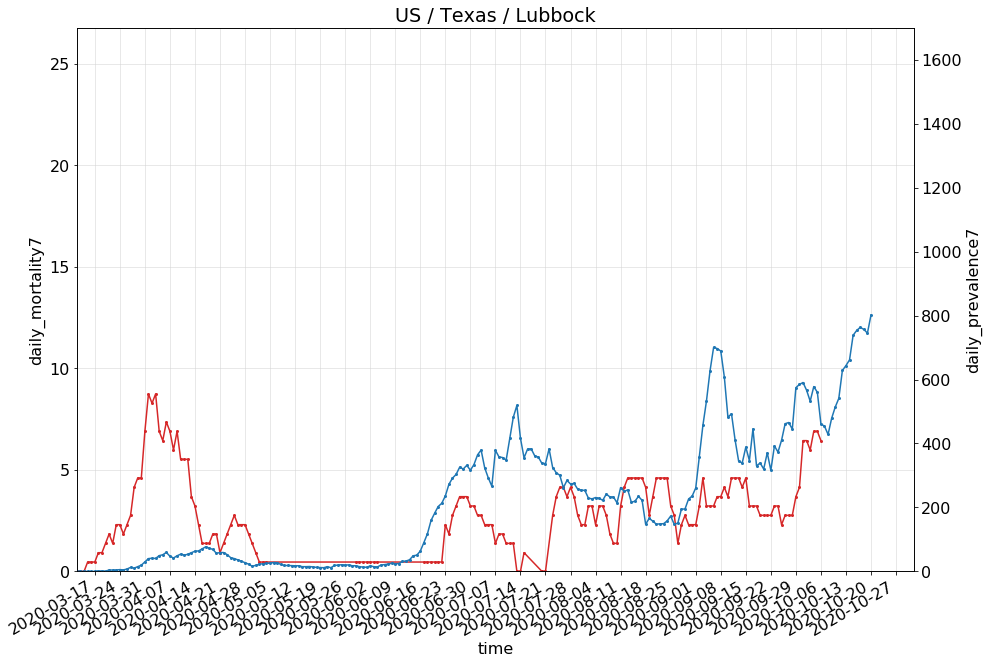

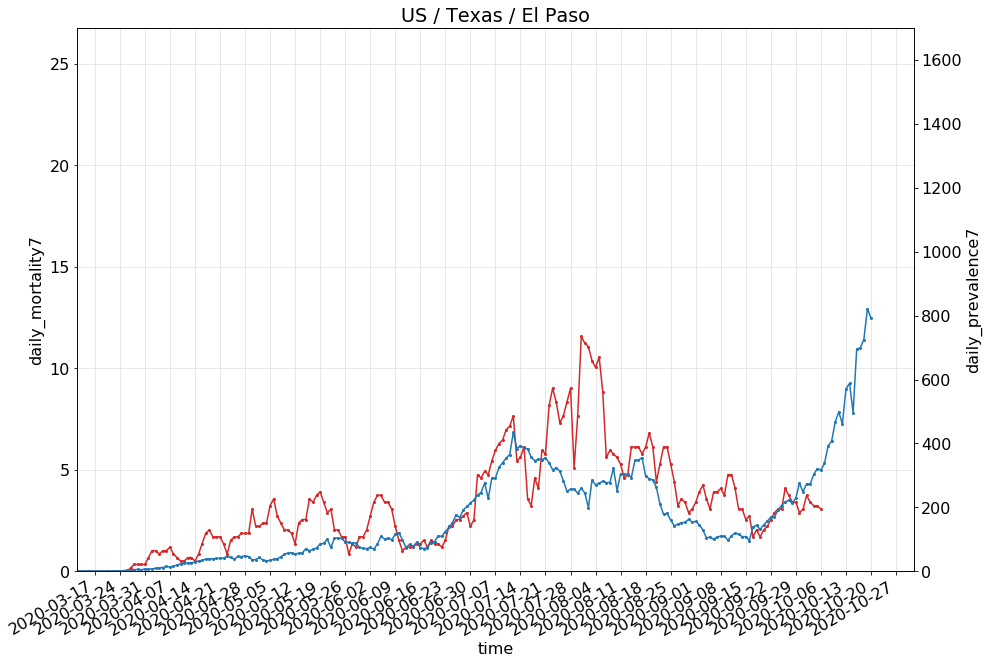

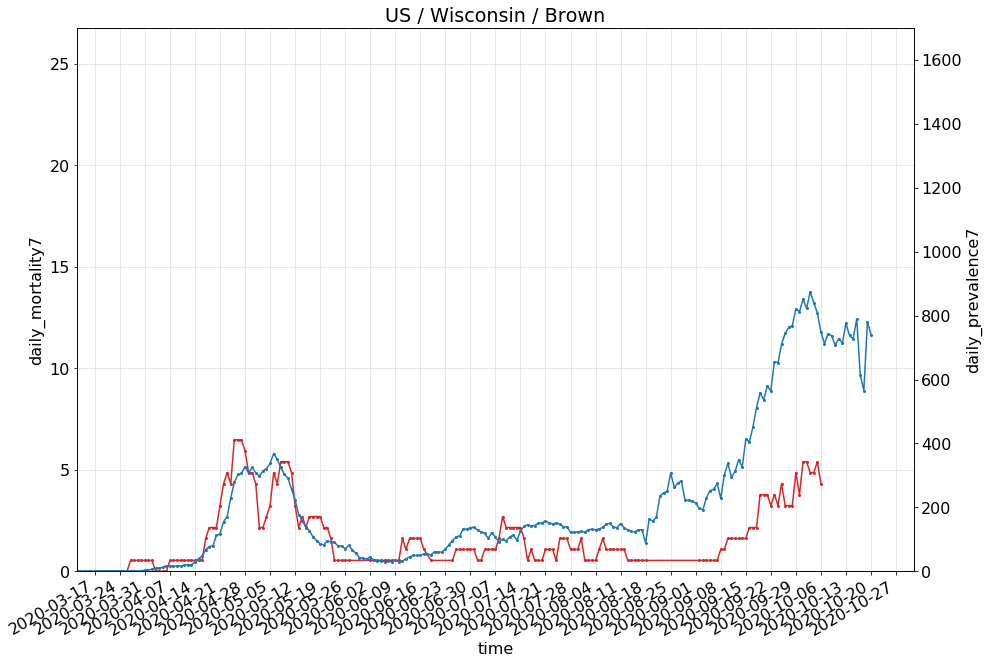

In [113]:
tmp = ds_counties.sortby(-ds_counties['daily_prevalence7'].isel(time=-1))
for location in list(tmp.sel(location=tmp['population'] > 100_000).location.values)[:10]:
    _, ax1 = plt.subplots(subplot_kw={'xlim': XLIM})

    ax1.yaxis.tick_right()
    ax1.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax1.xaxis.grid(color='lightgrey', linewidth=0.5)

    ds = ds_counties.sel(location=location)

    ax2 = ax1.twinx()
    
    covid19.plot.plot_data(ax1, ds['daily_mortality7'], color=PALETTE_ONE[3], delay=-14)
    covid19.plot.plot_data(ax2, ds['daily_prevalence7'], color=PALETTE_ONE[0])

    ax1.set(ylim=(0, 1700. * 0.01575), title=location)
    ax2.set(ylim=(0, 1700.), title=None)

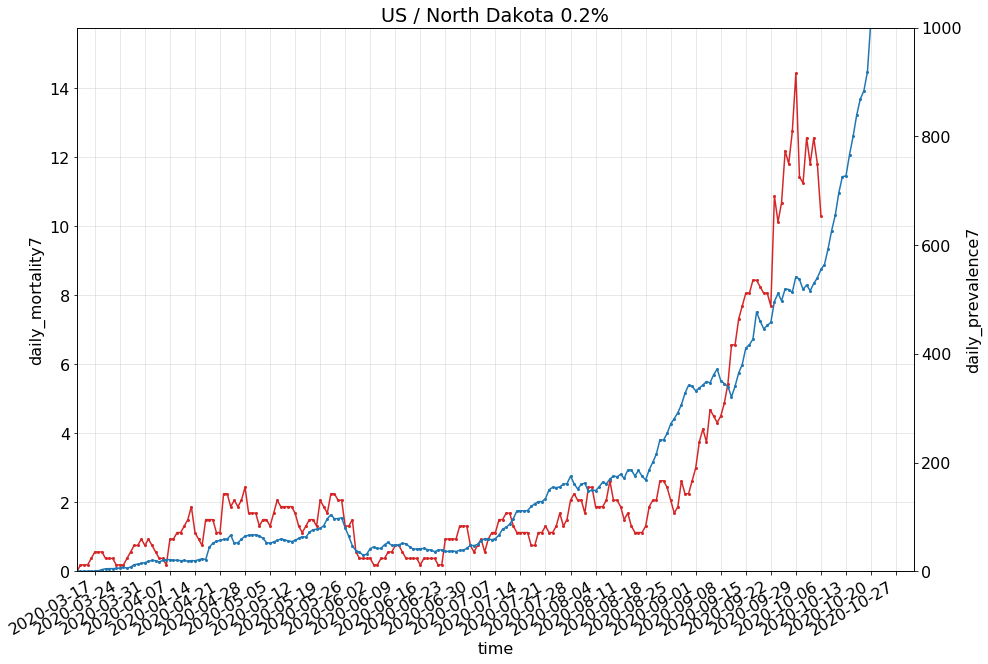

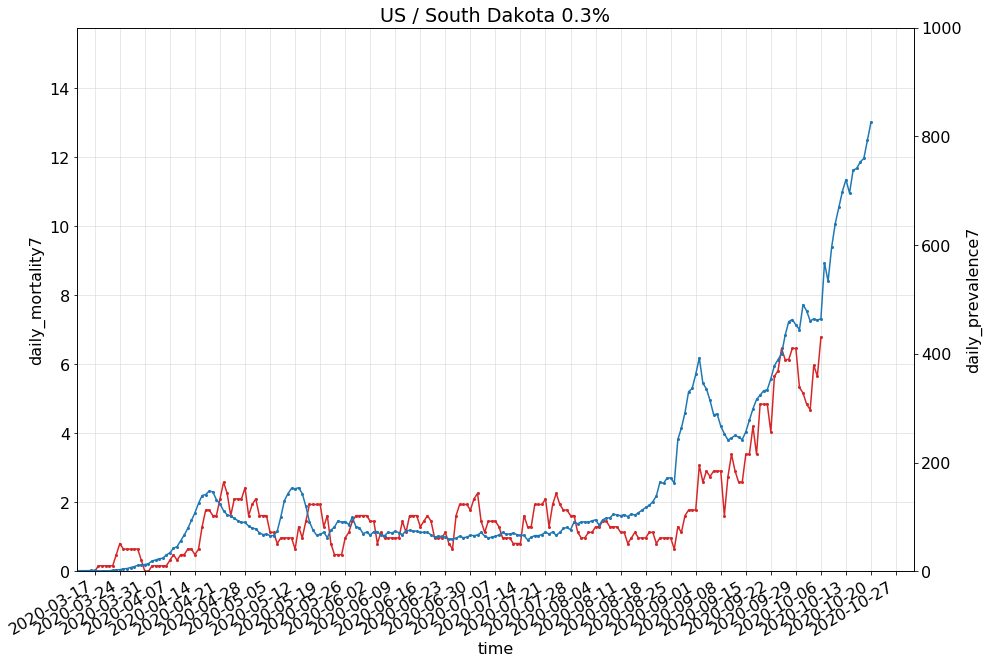

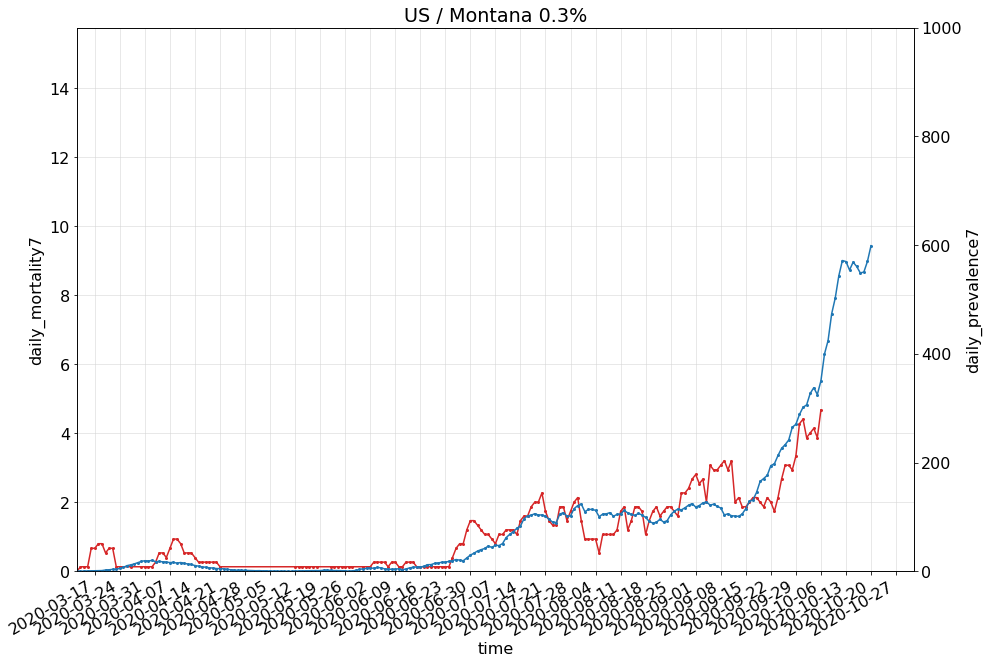

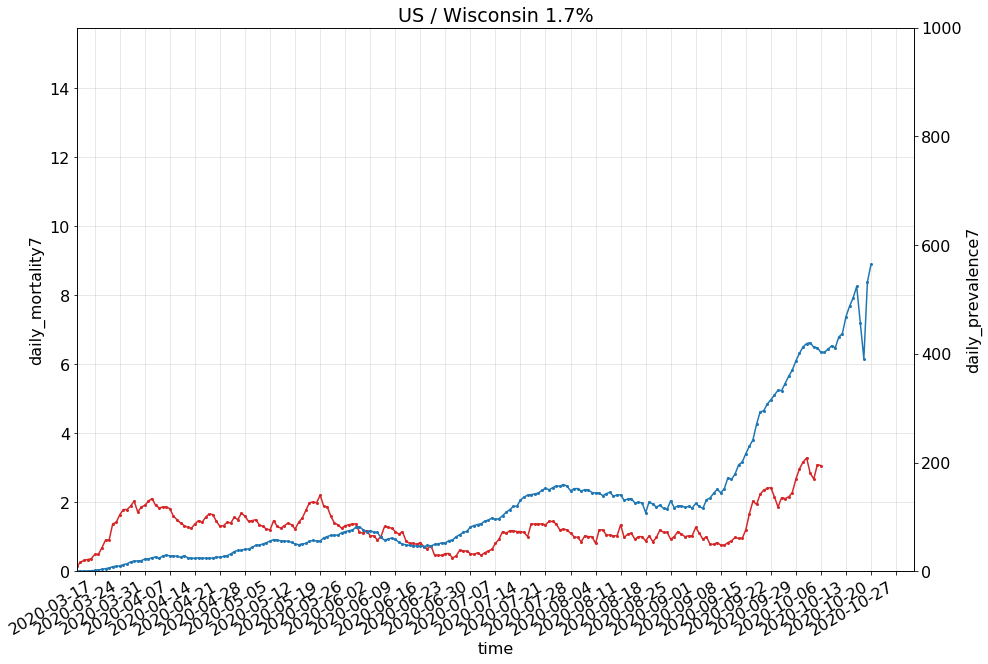

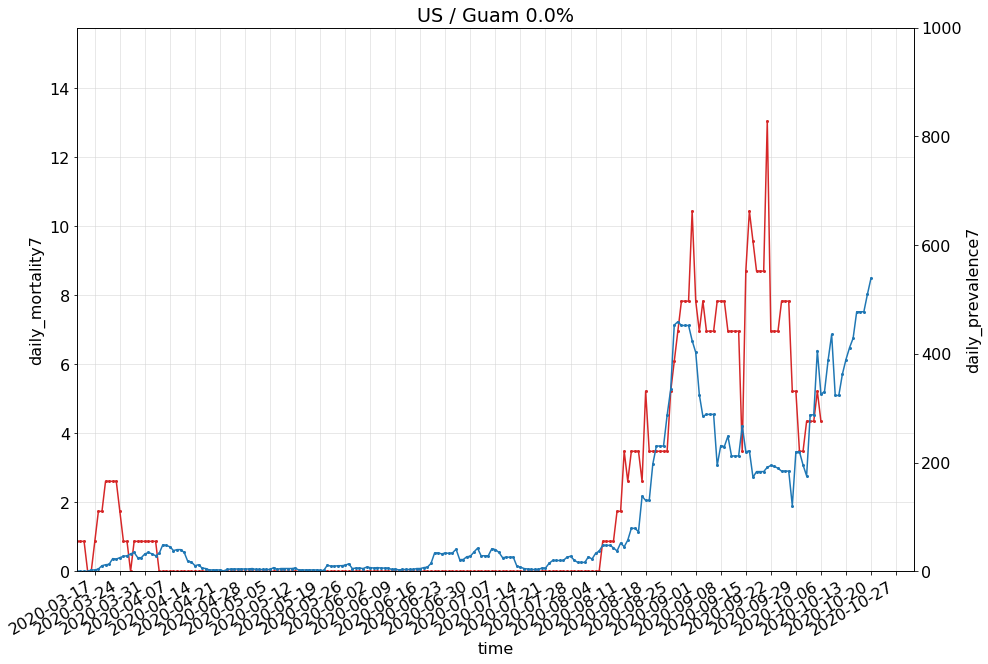

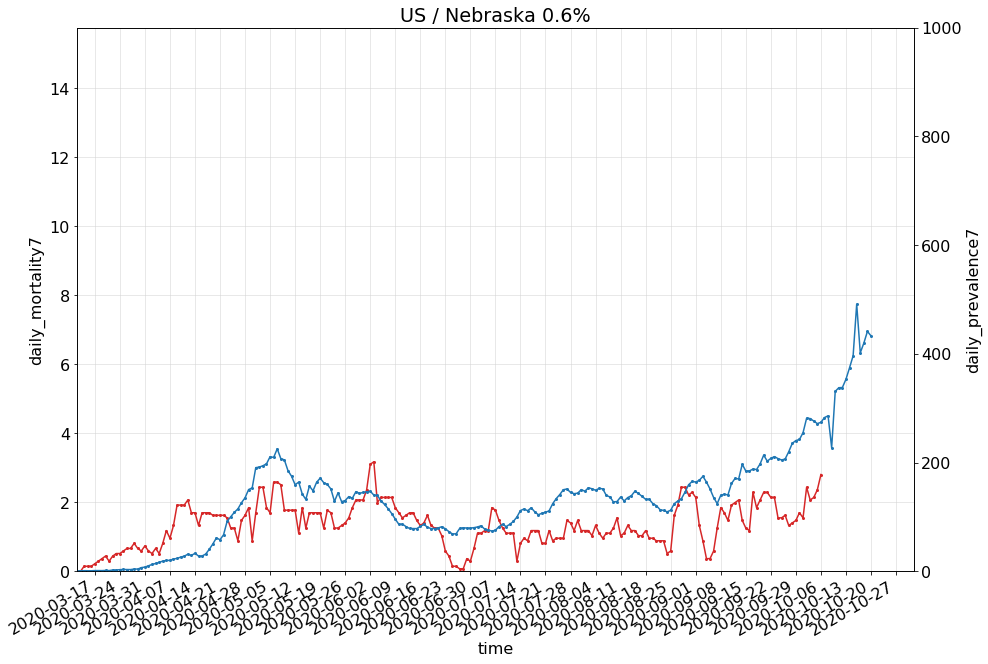

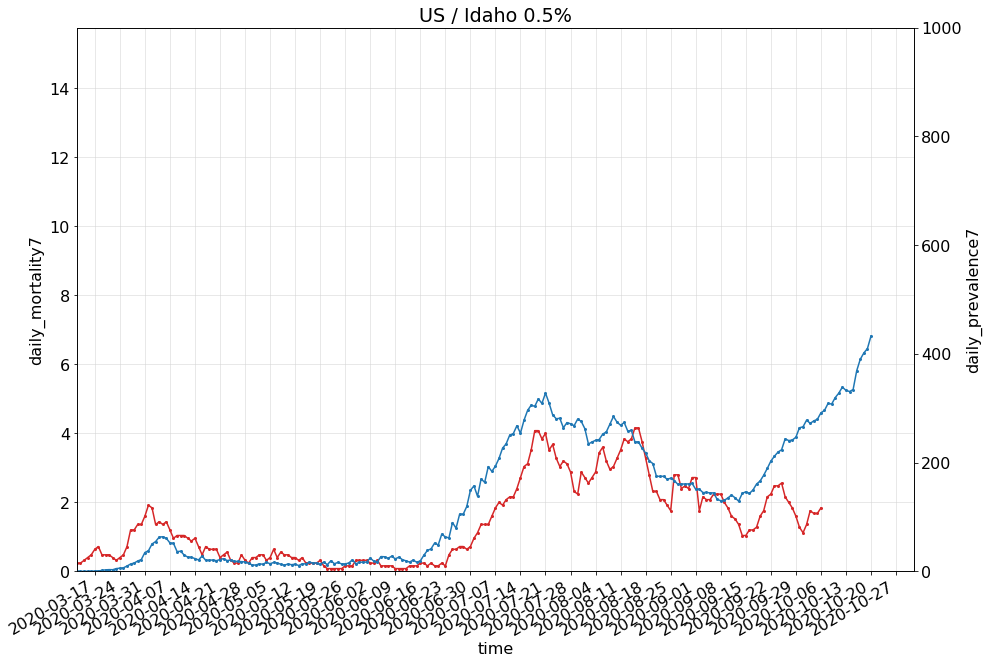

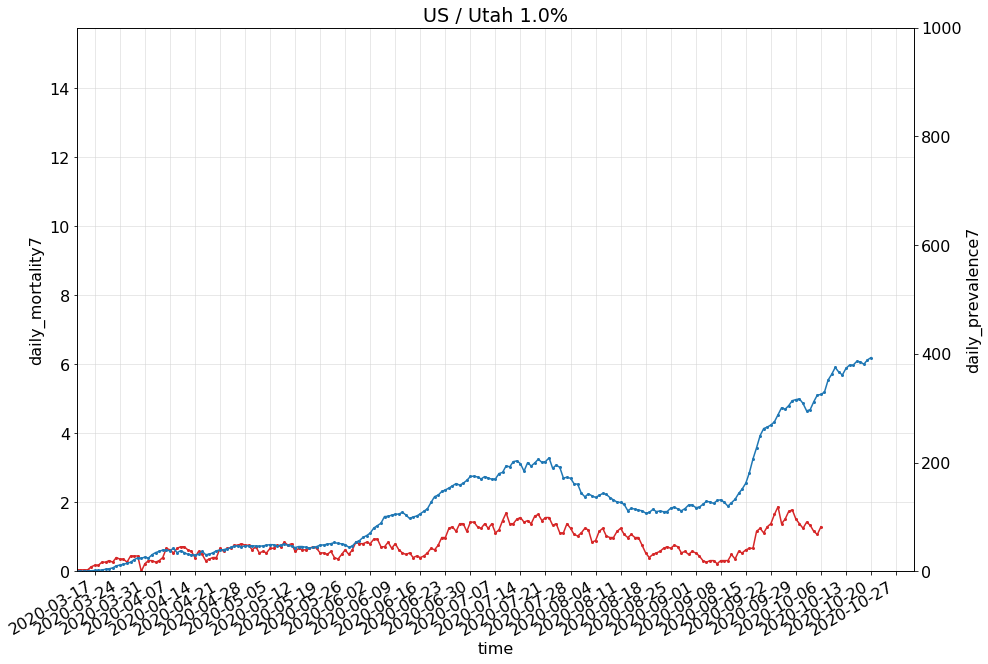

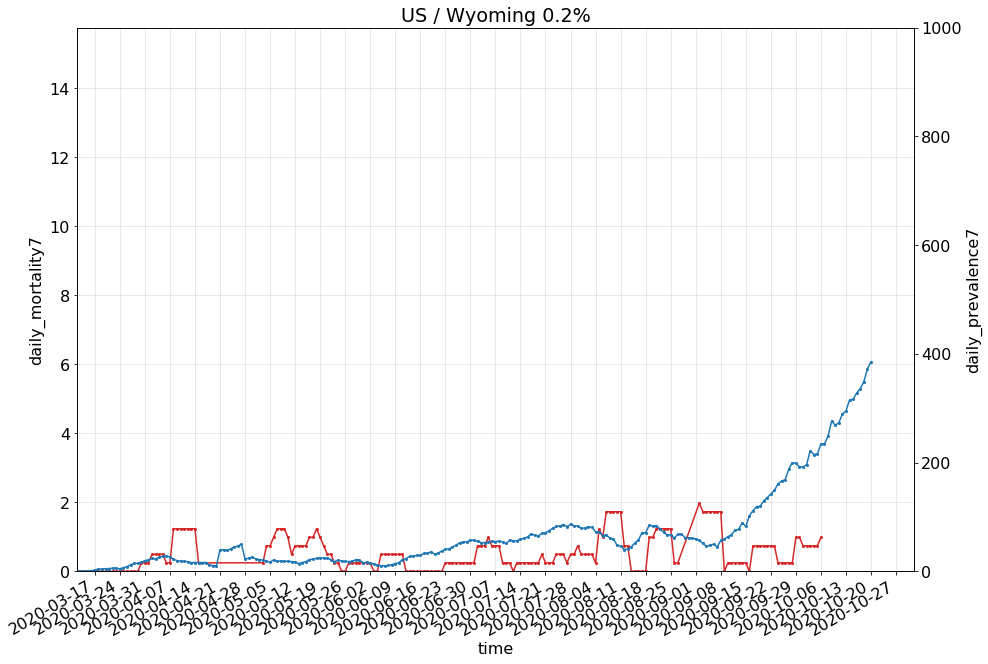

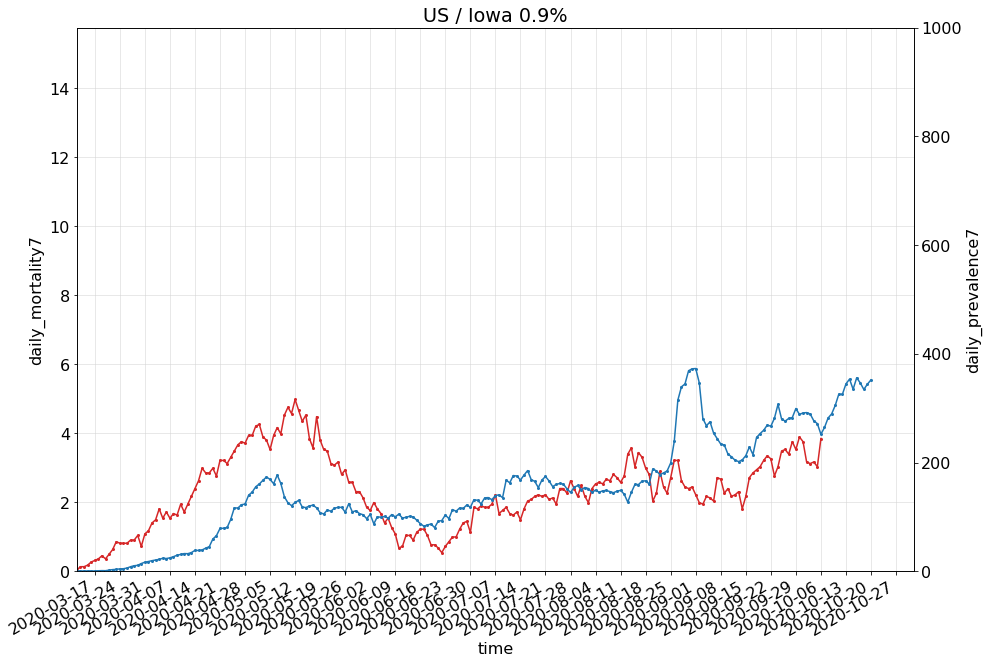

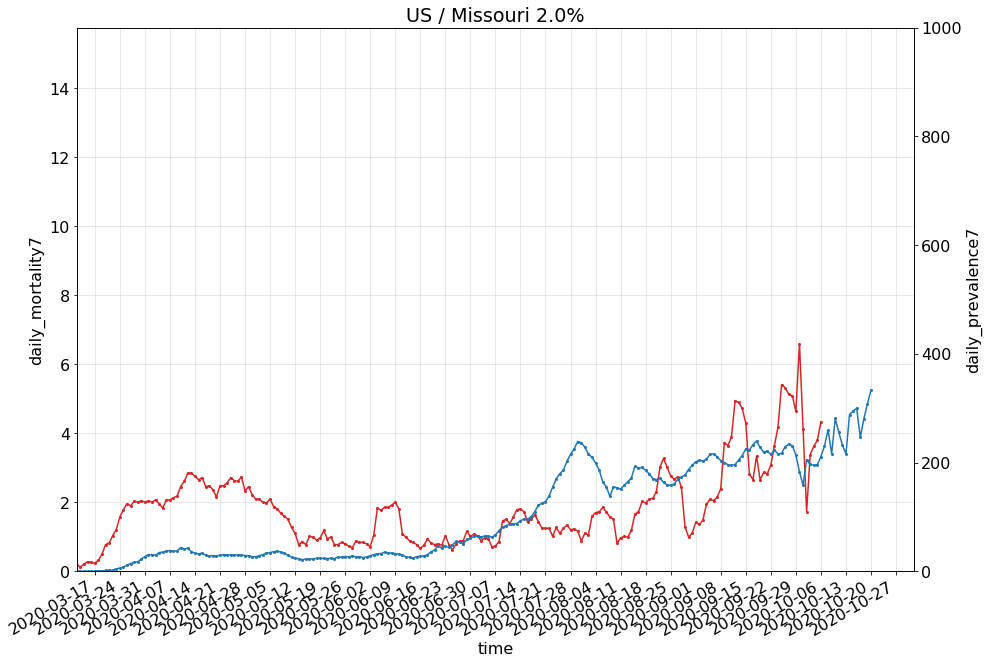

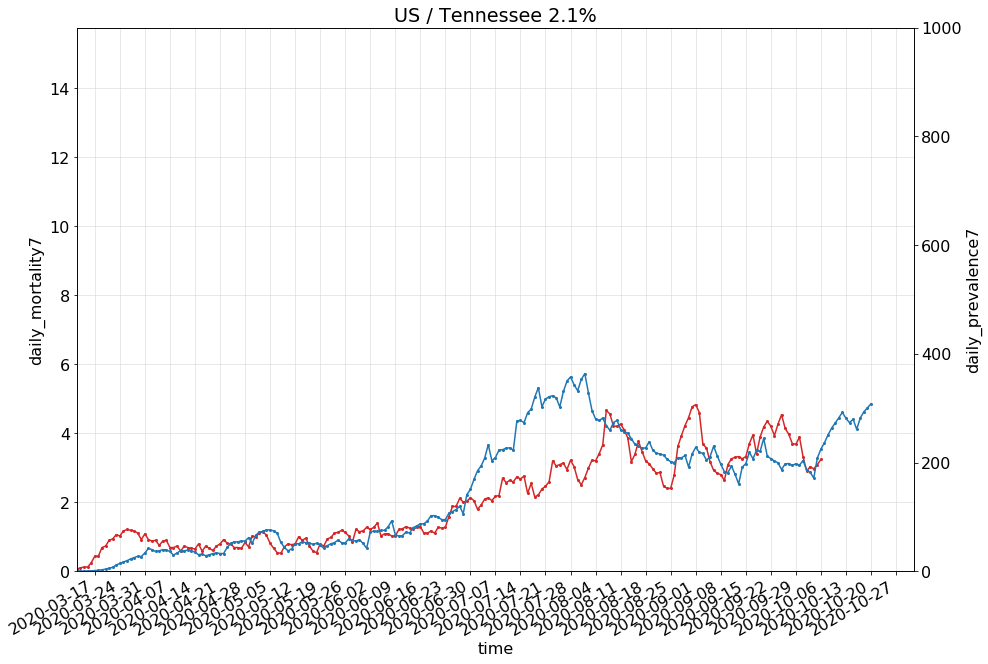

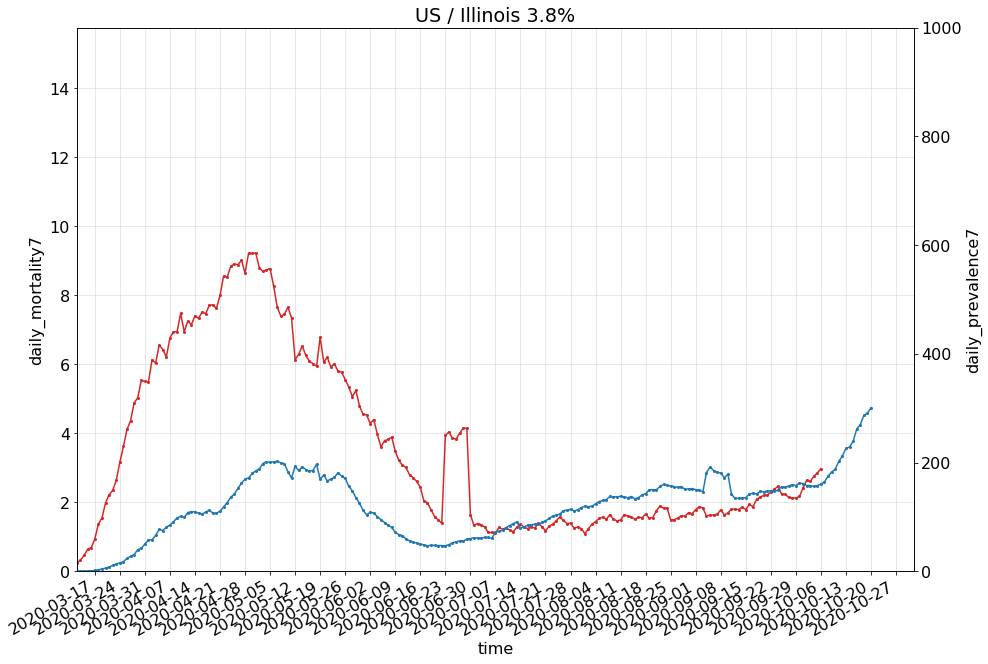

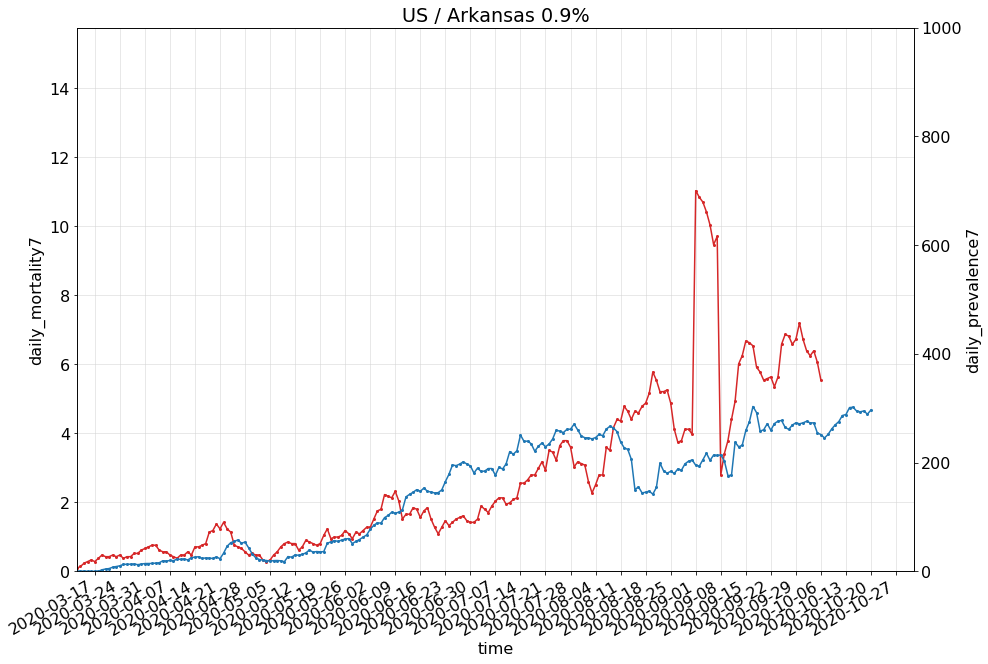

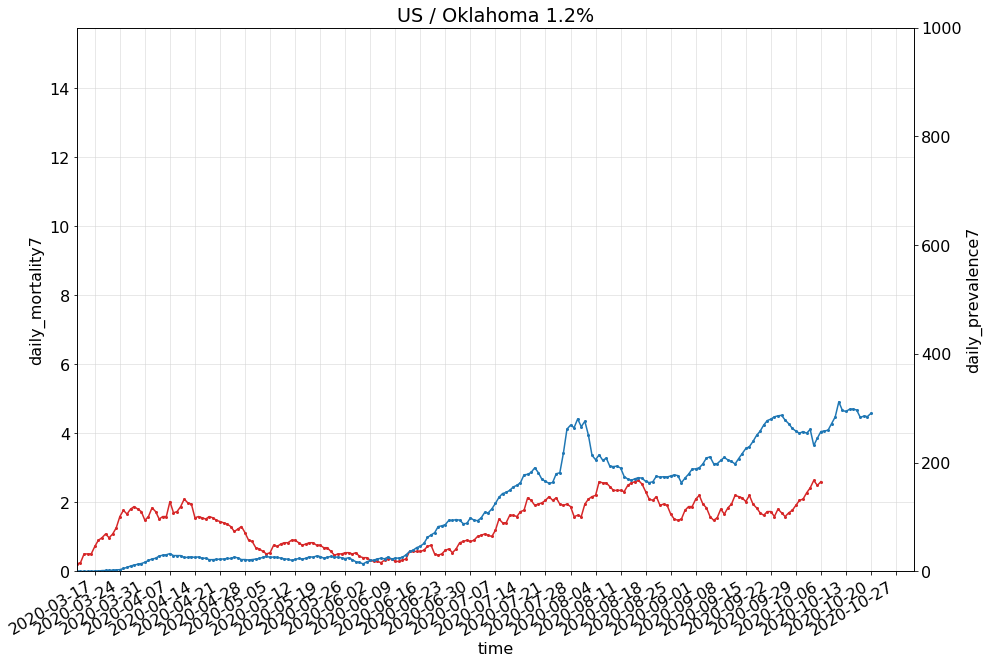

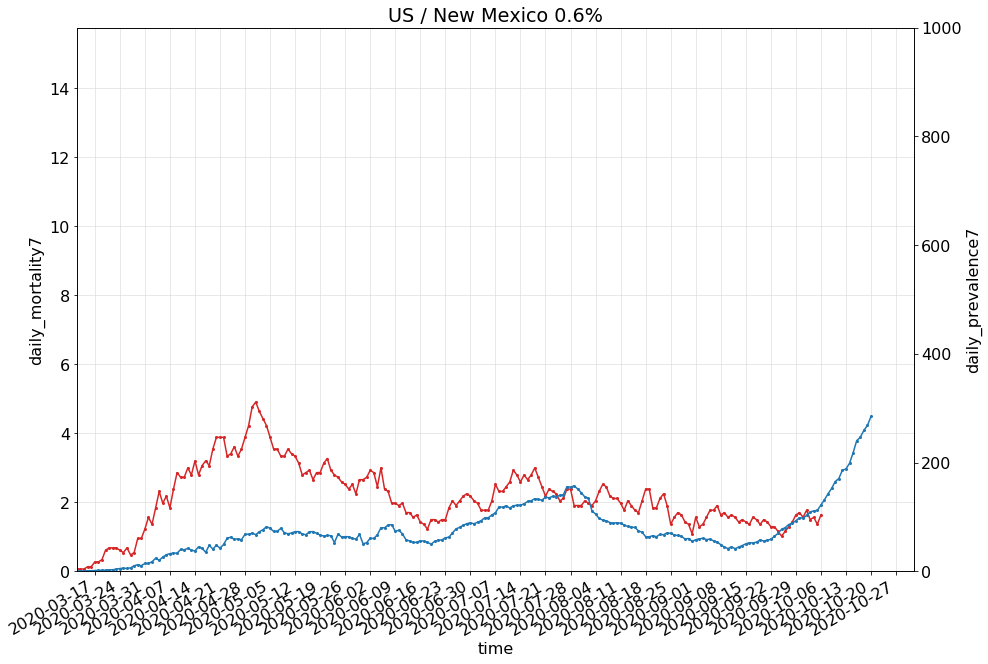

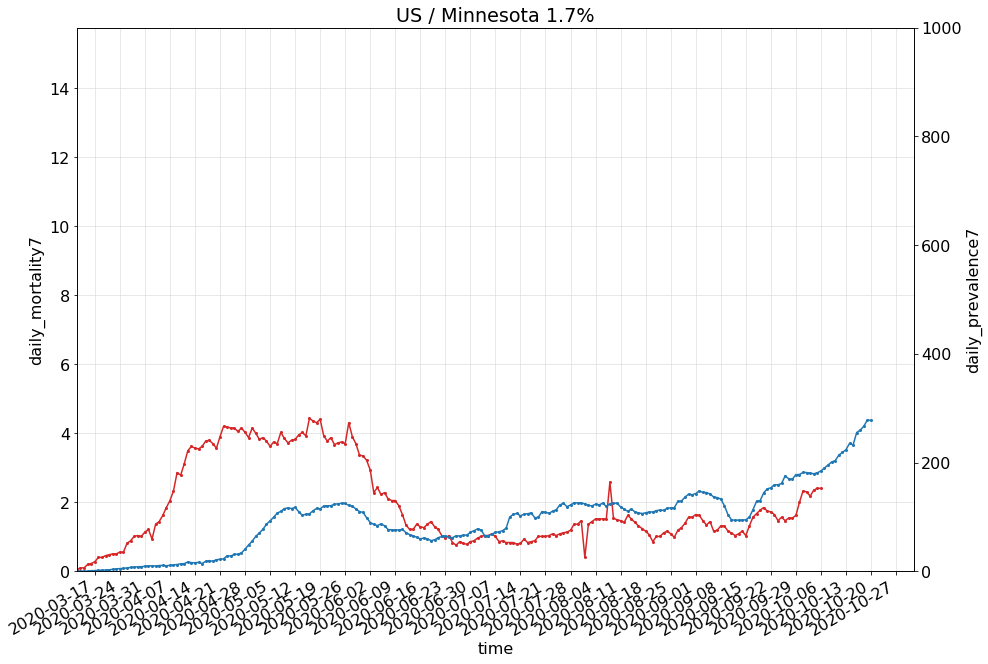

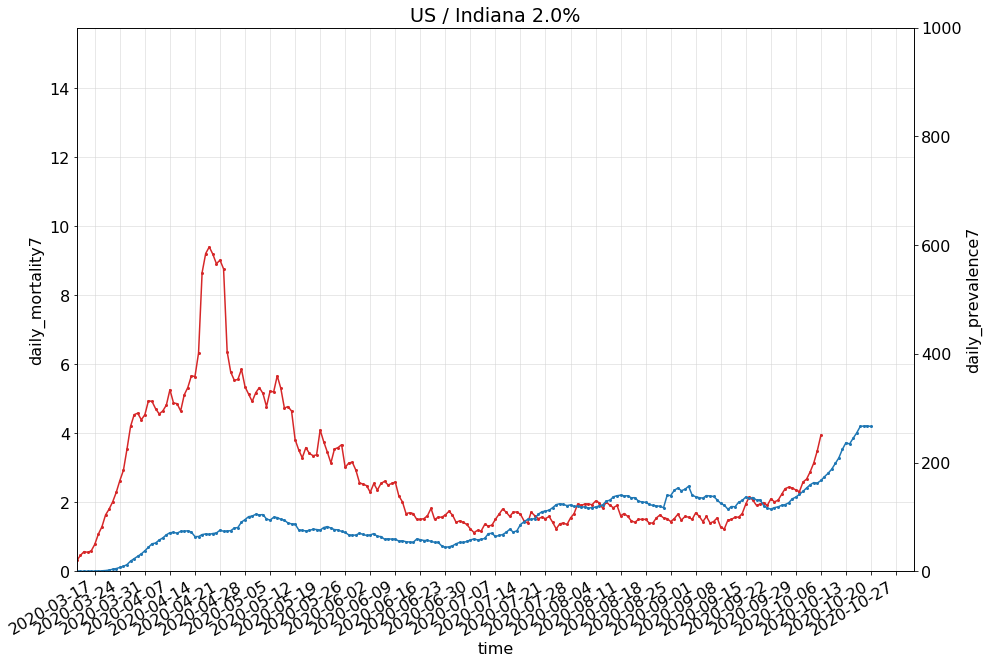

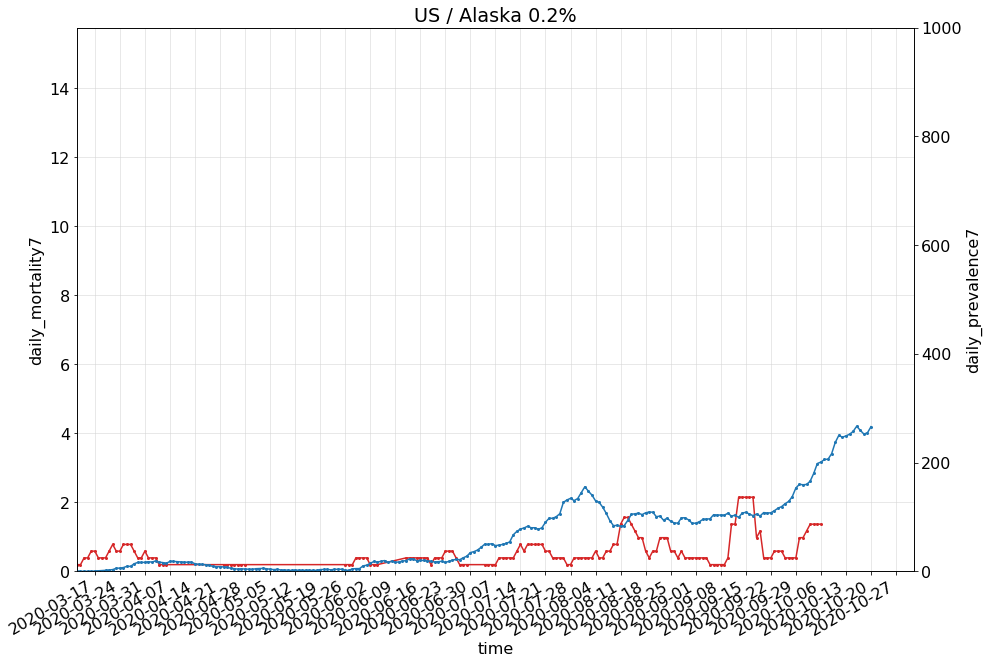

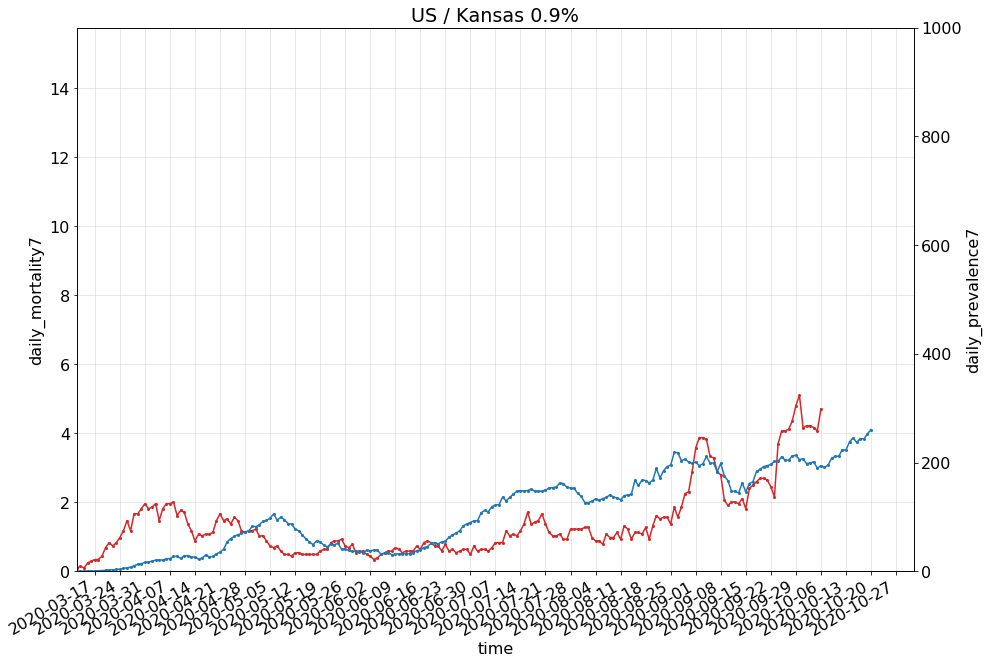

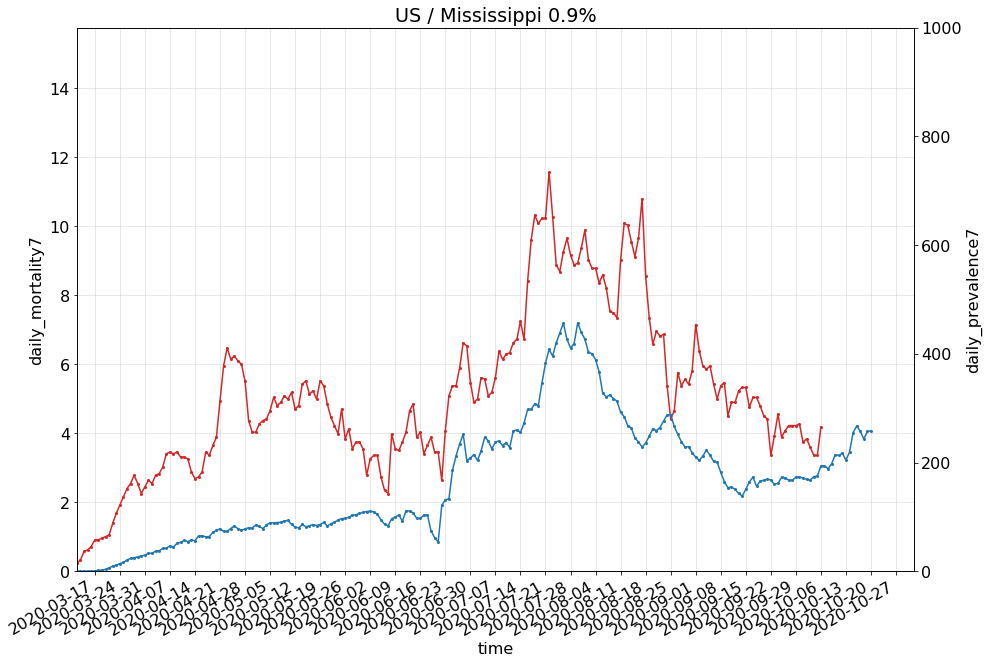

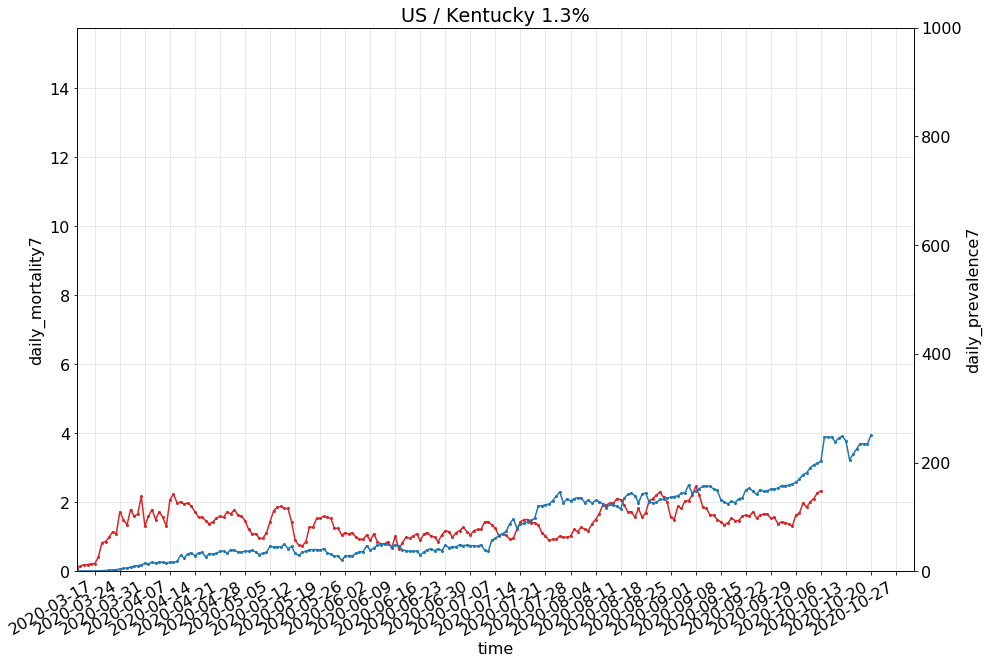

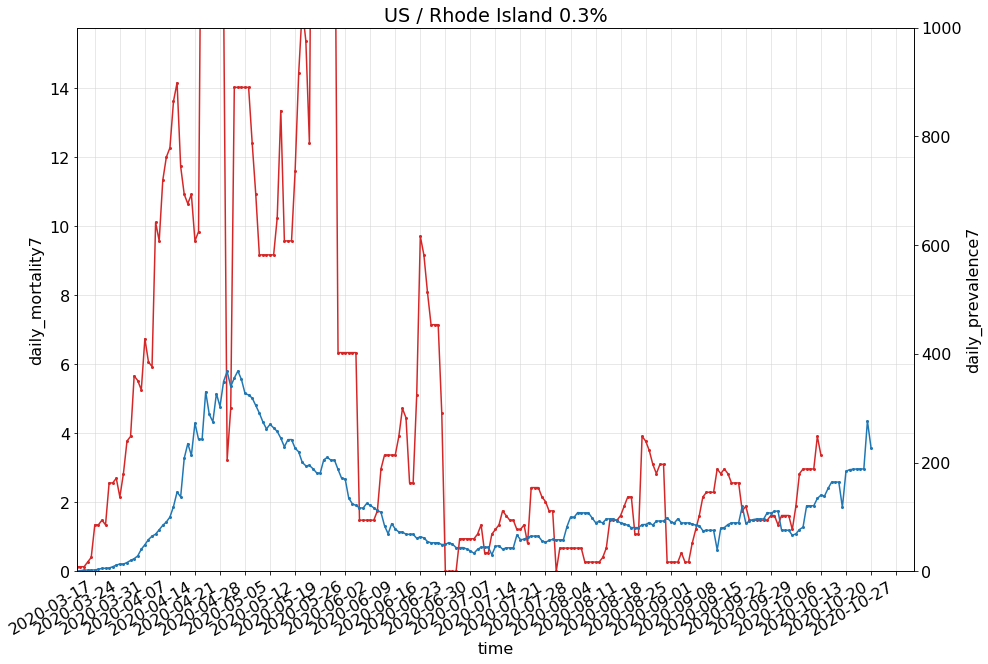

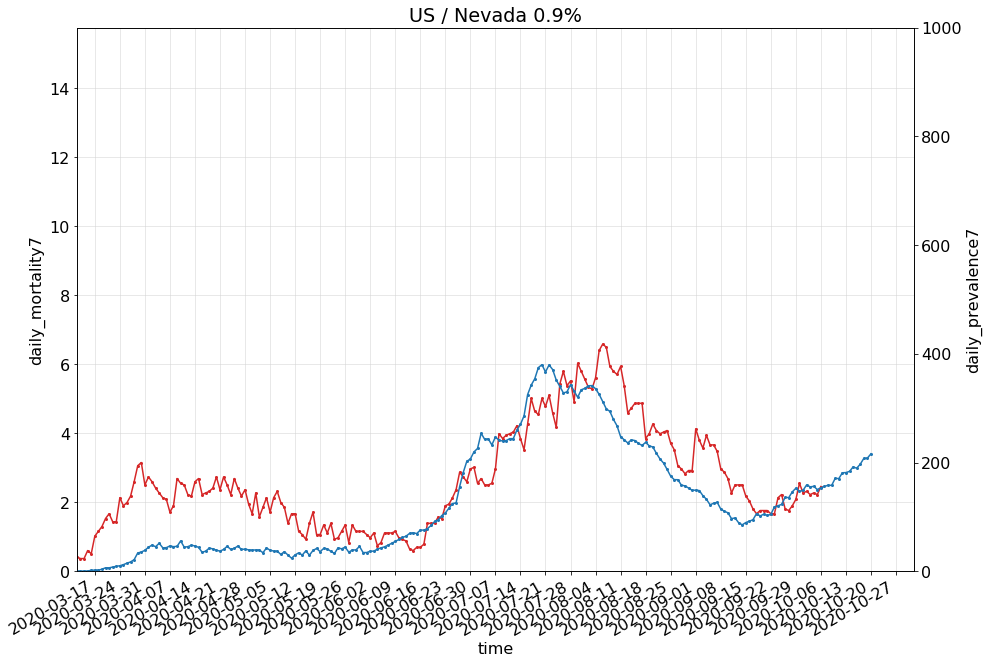

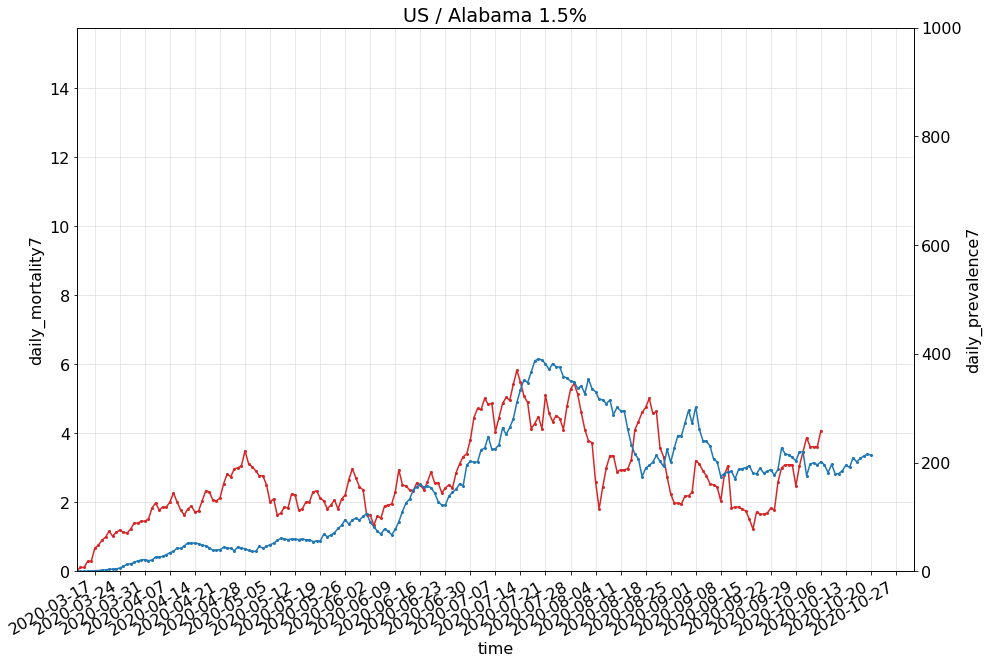

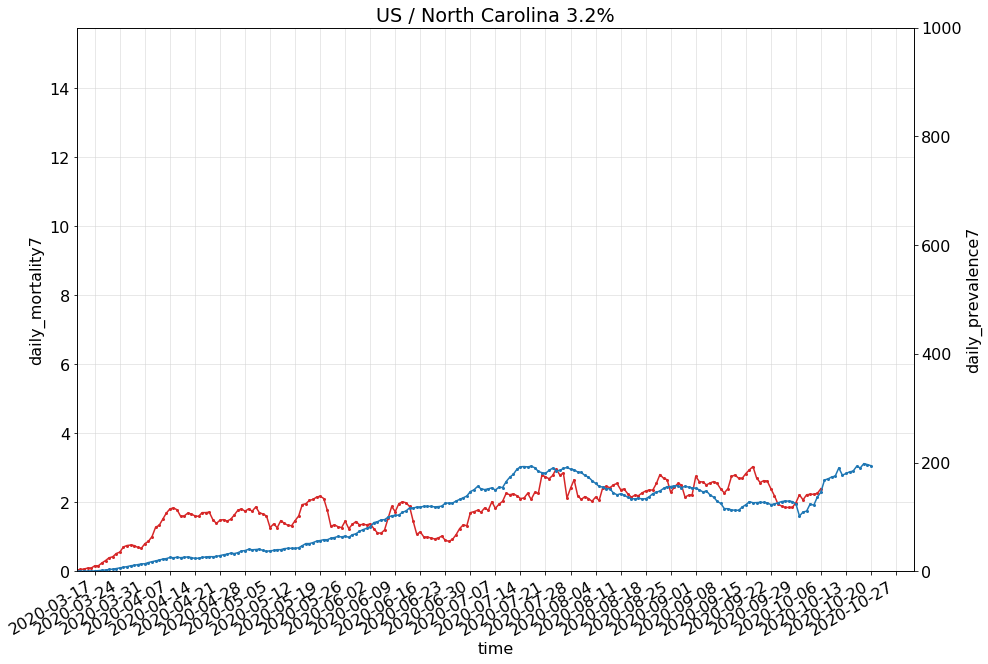

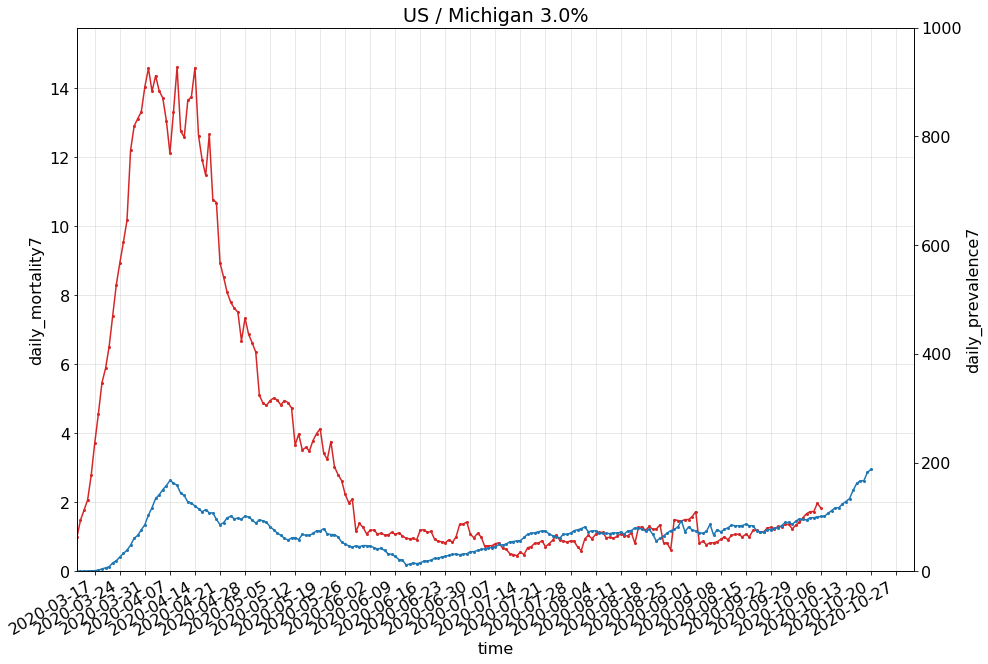

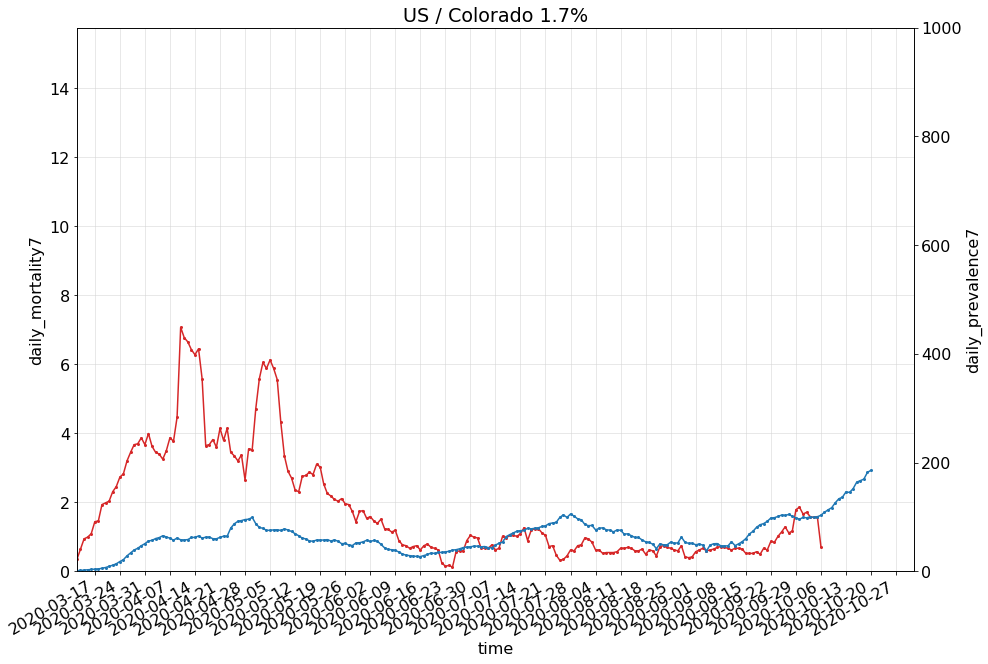

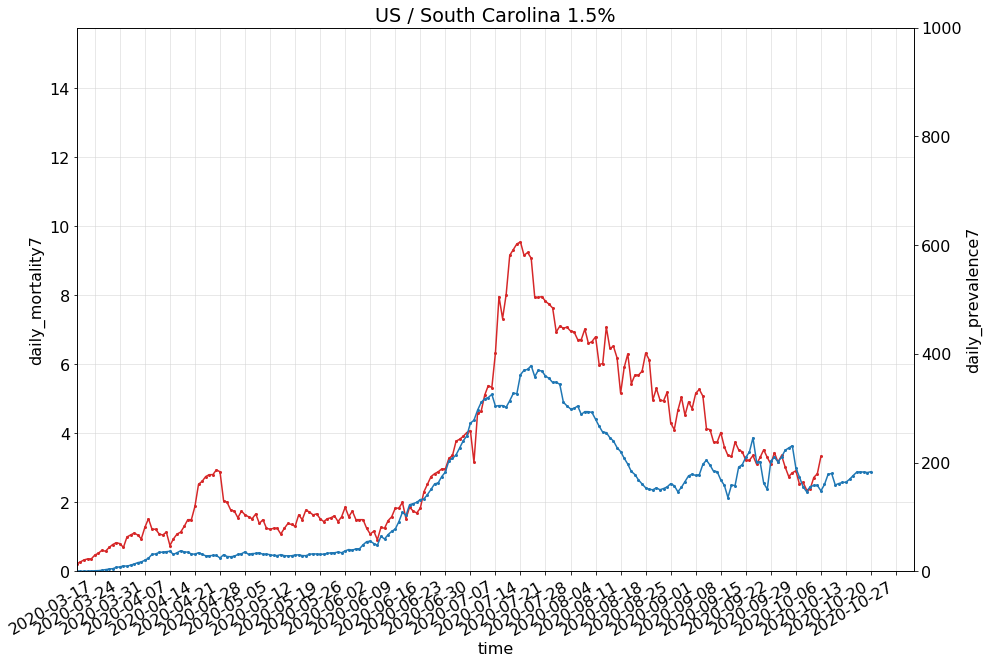

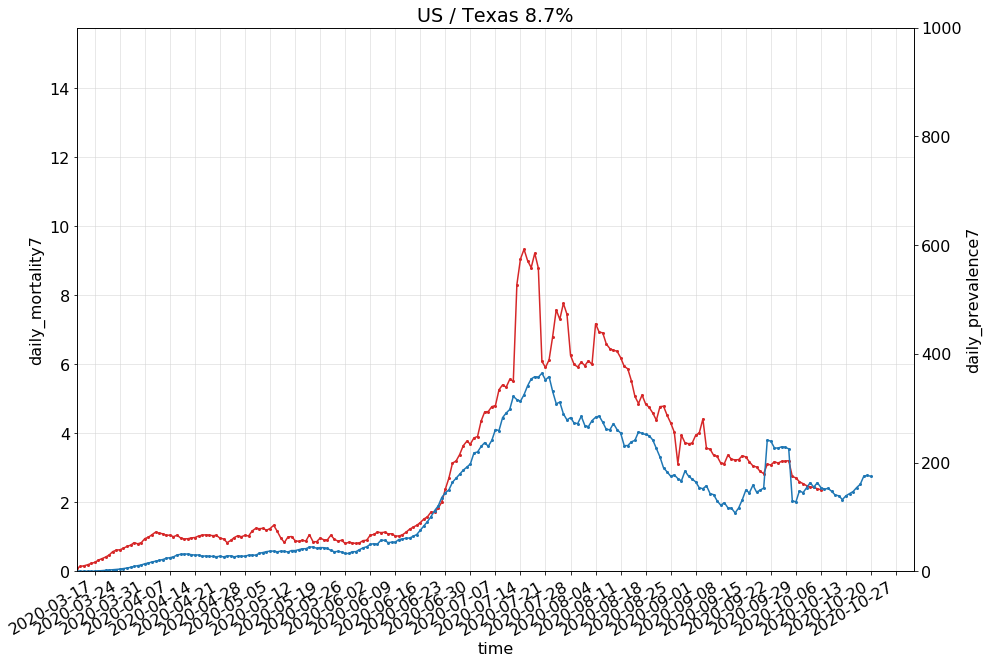

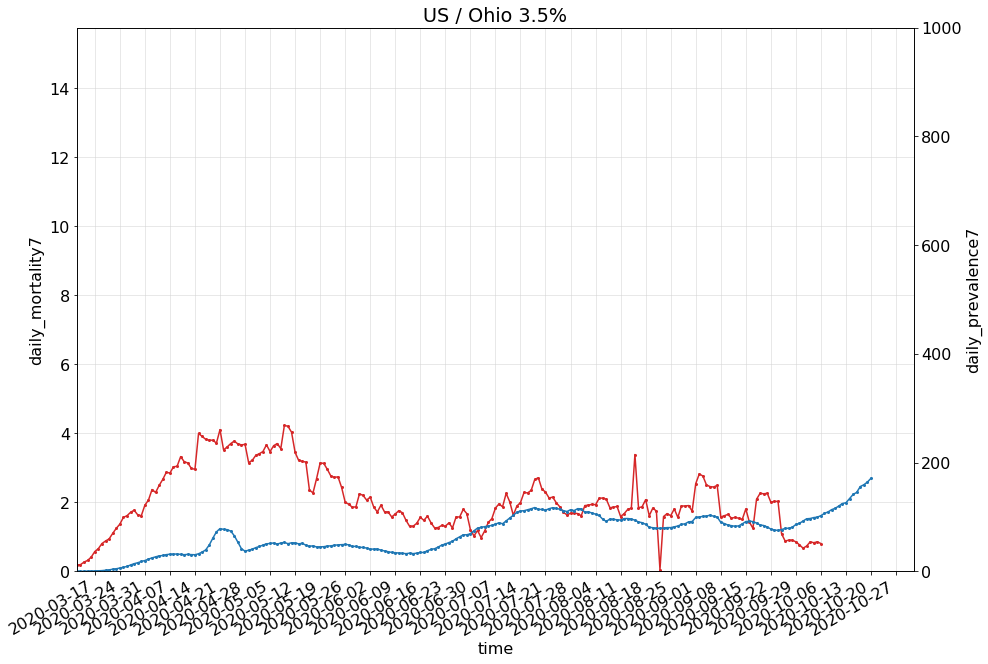

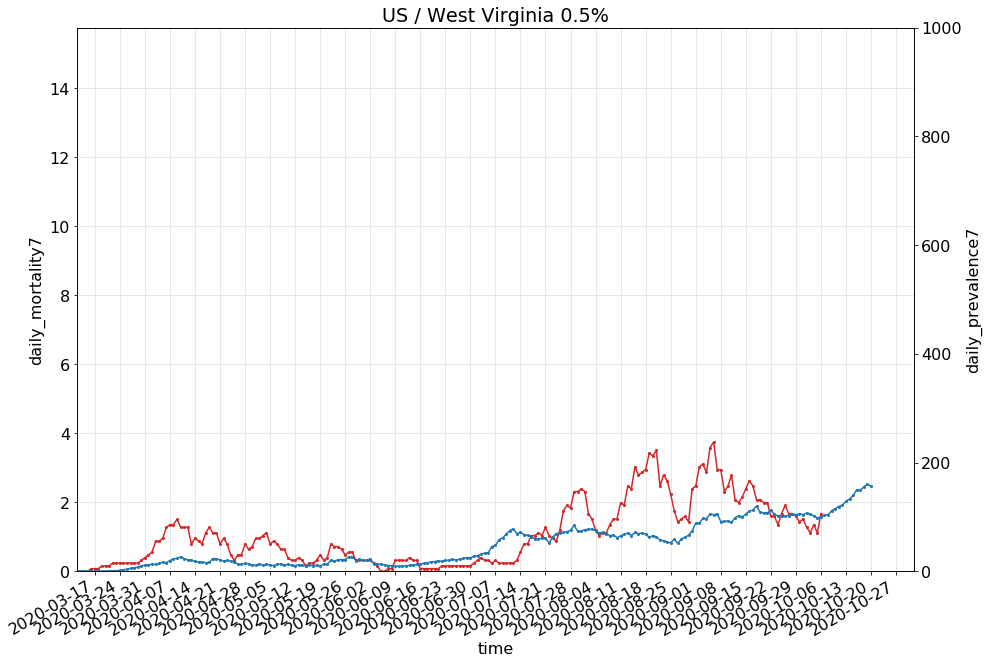

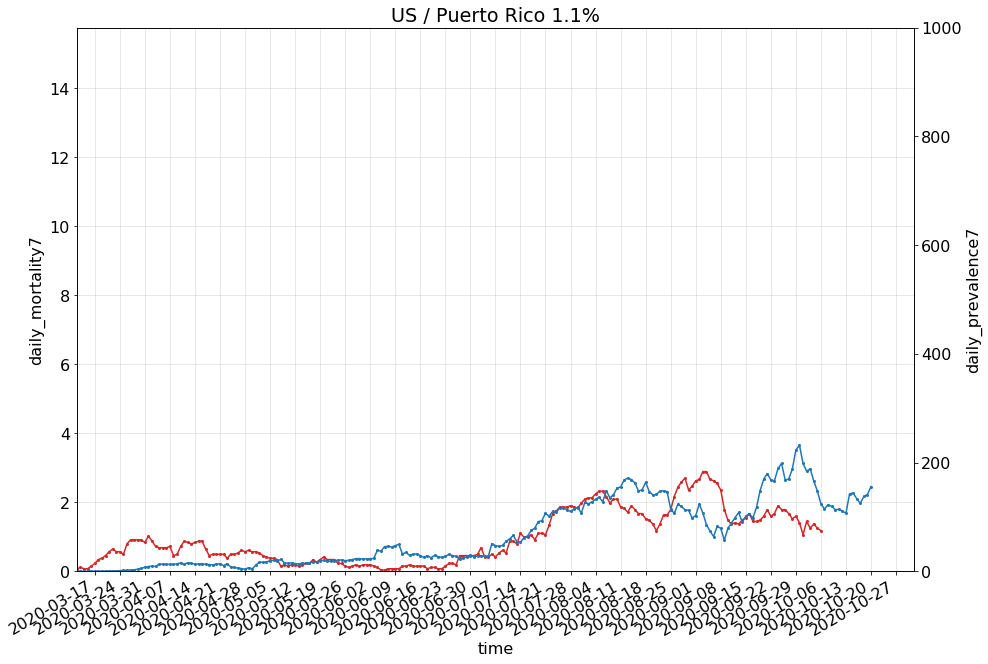

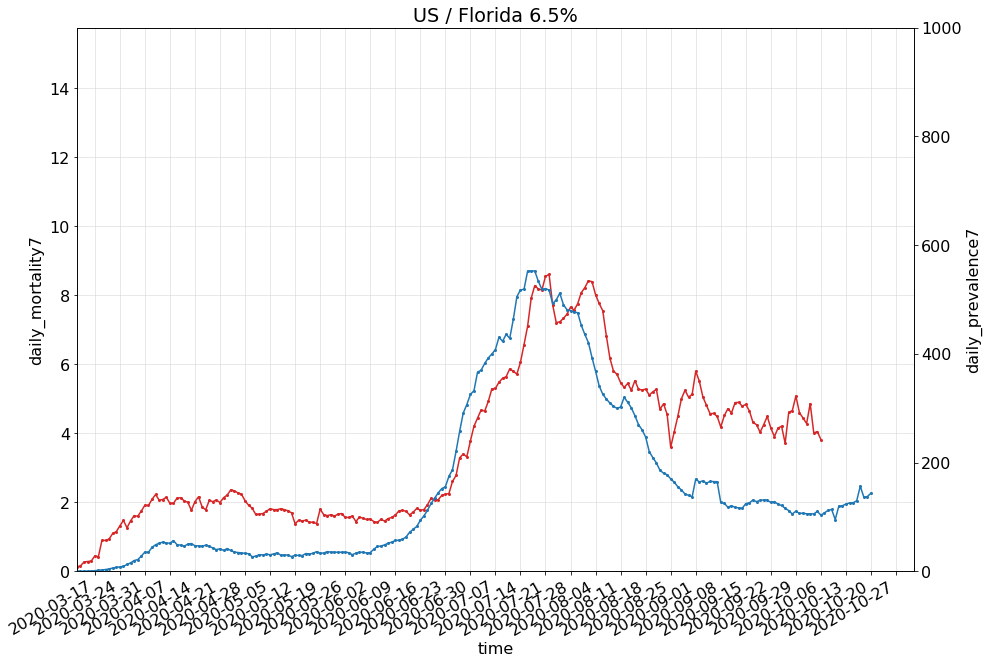

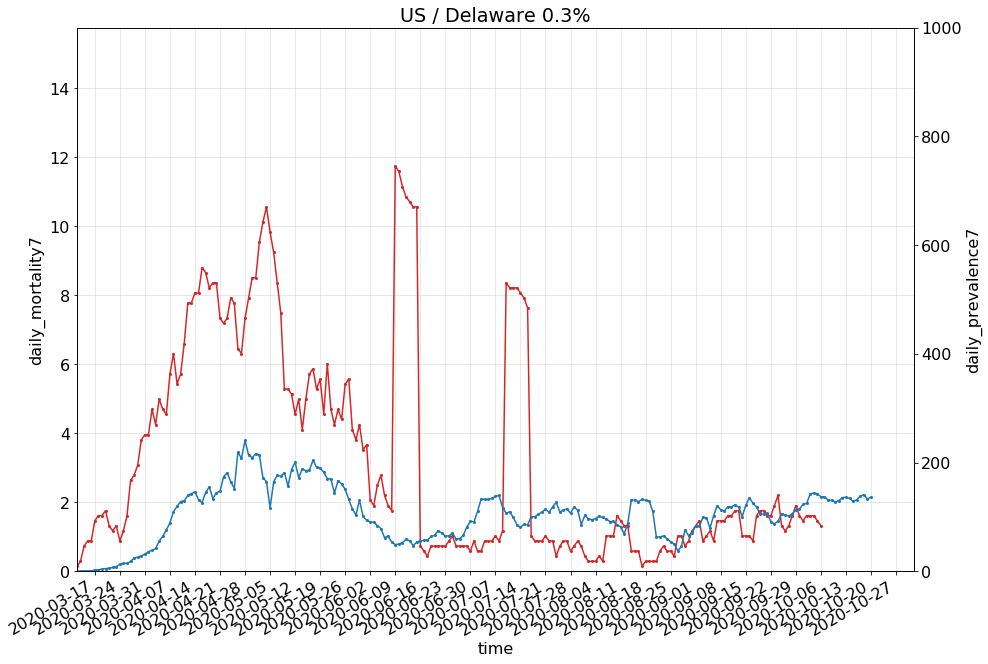

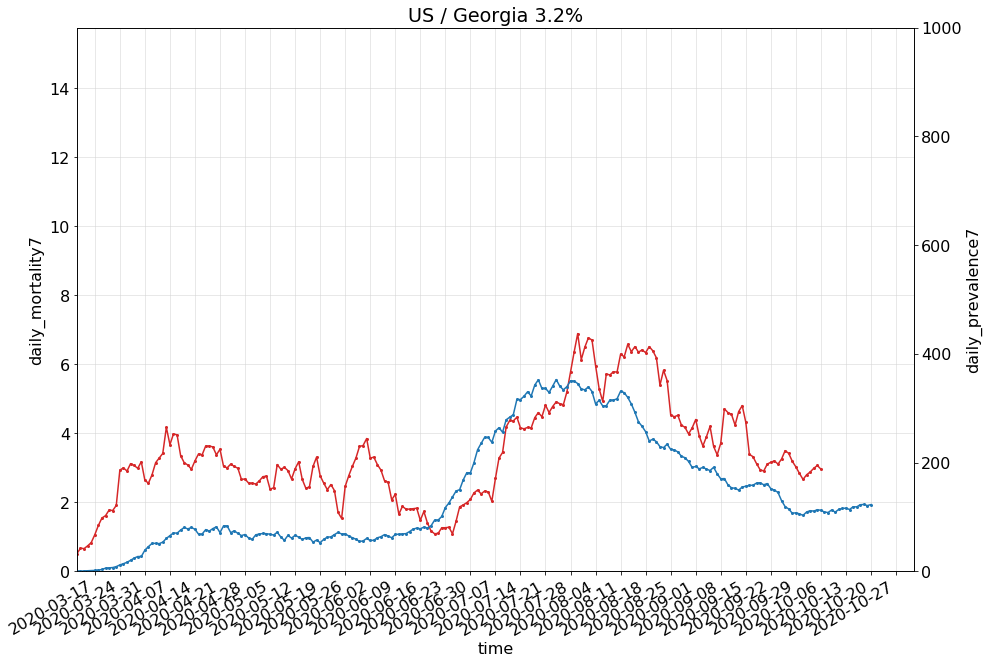

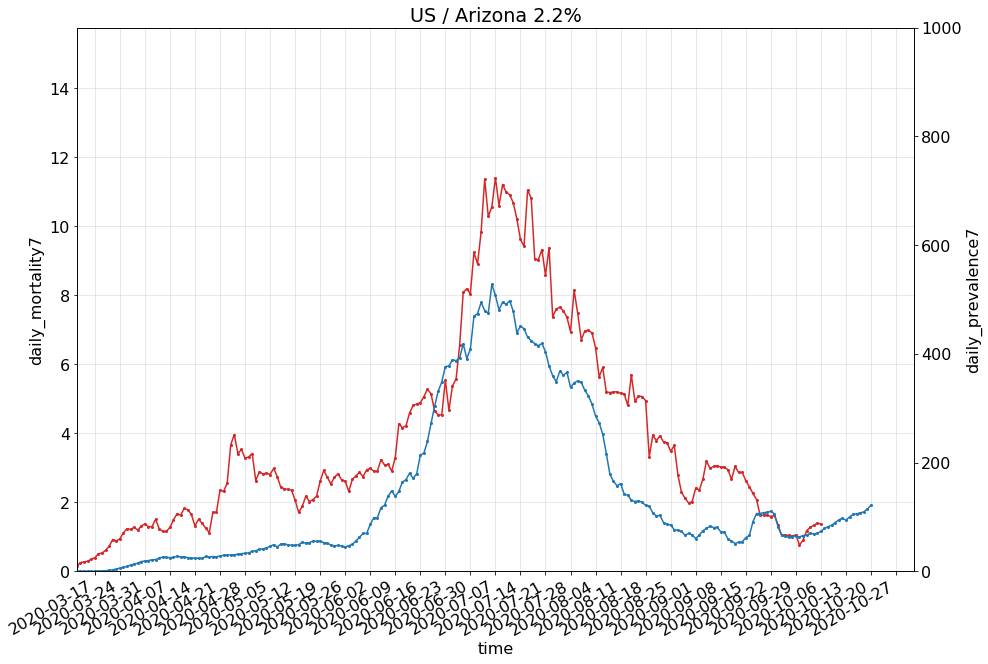

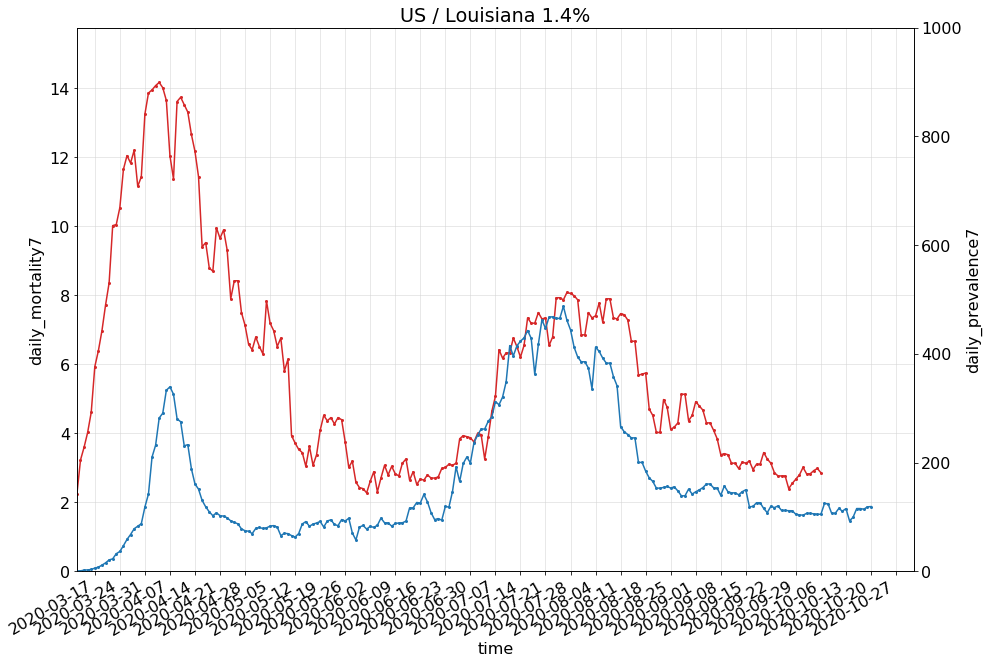

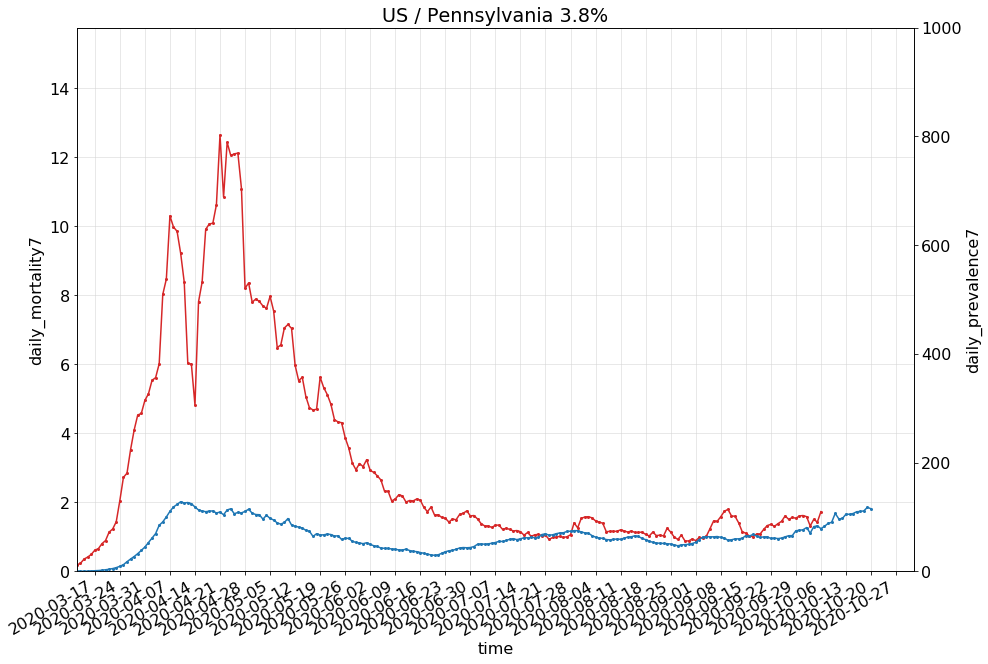

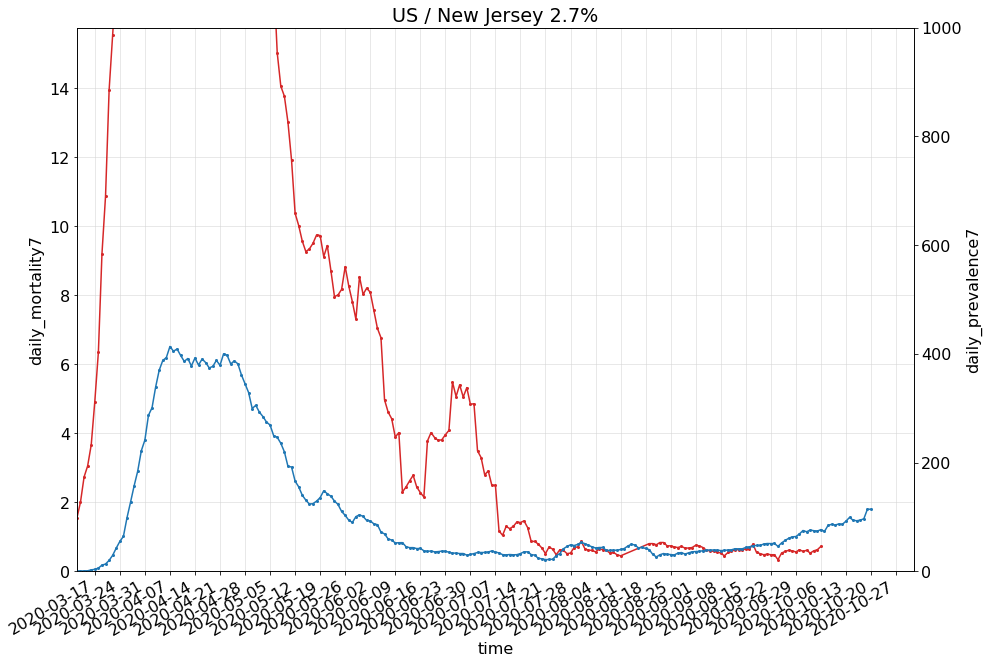

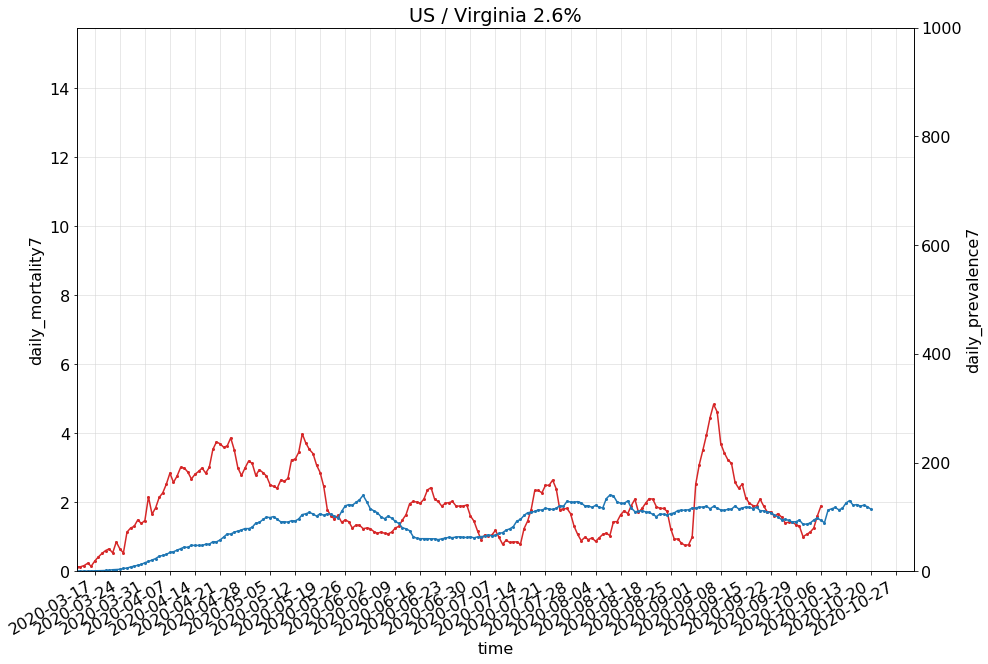

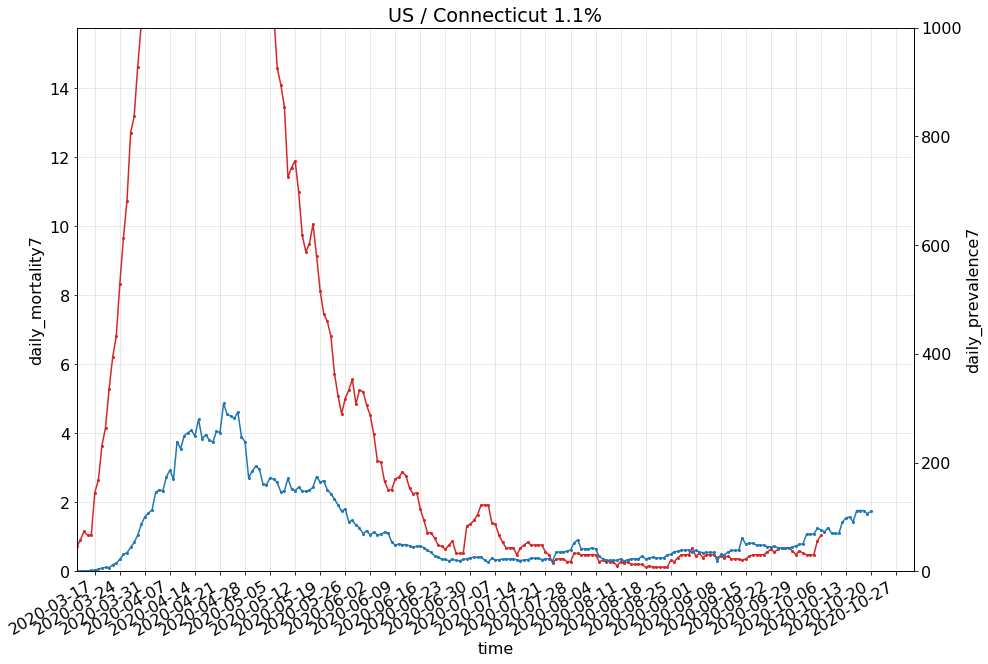

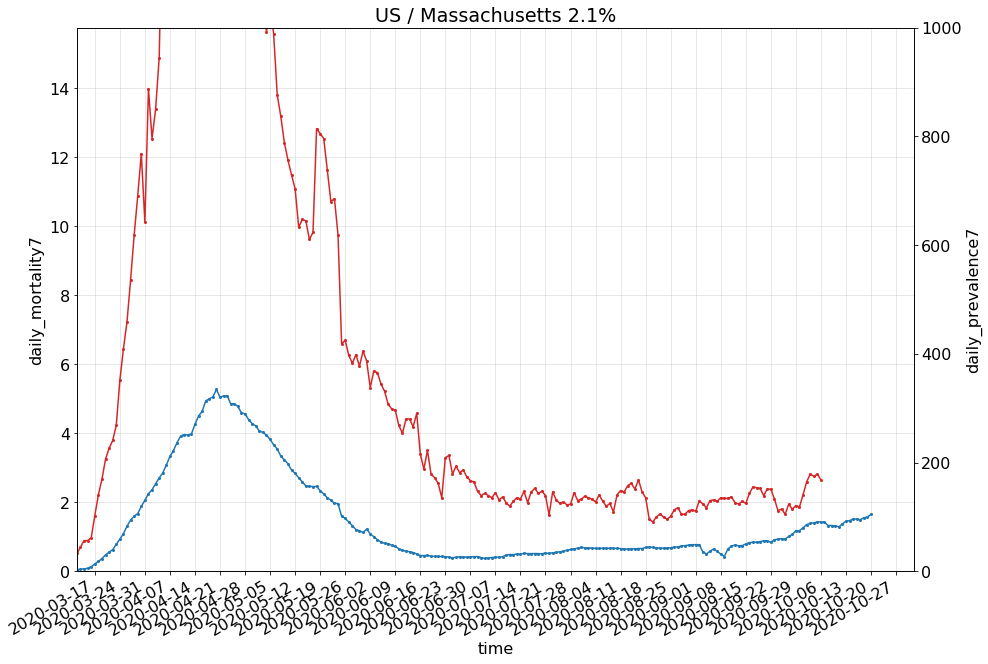

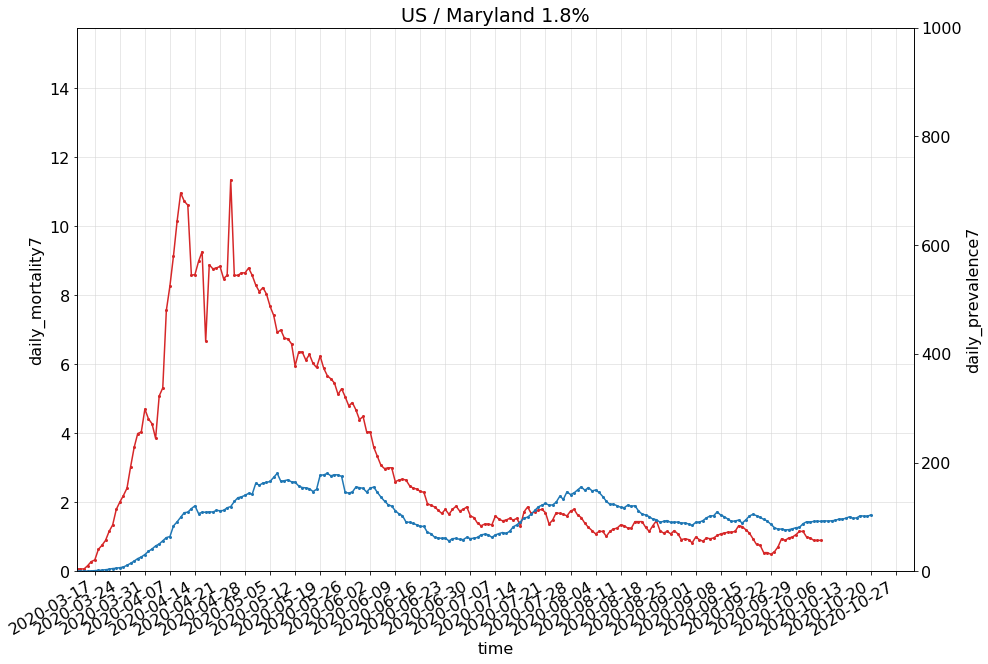

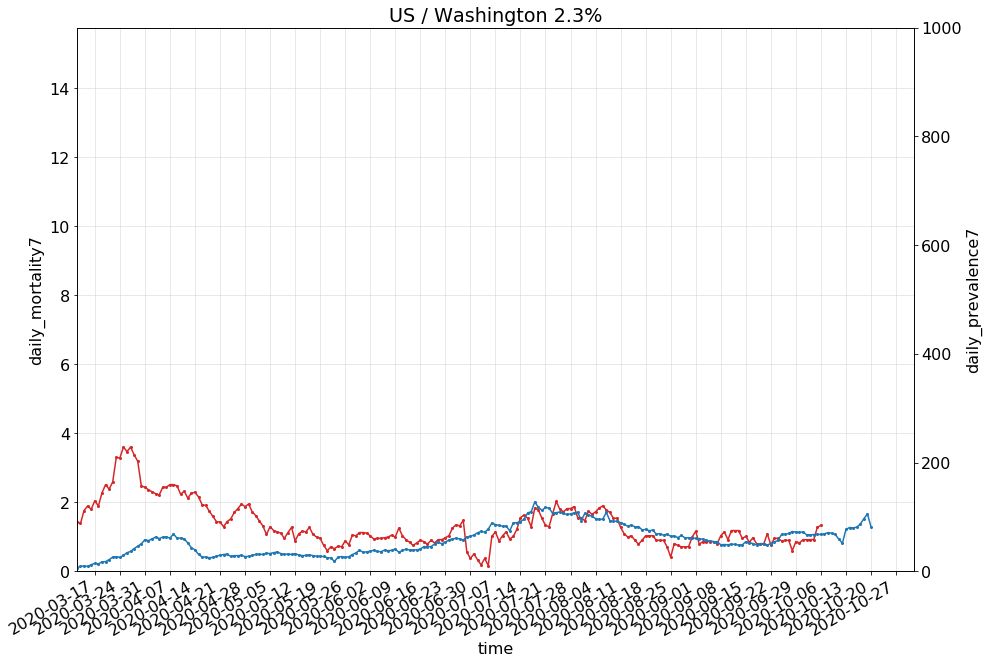

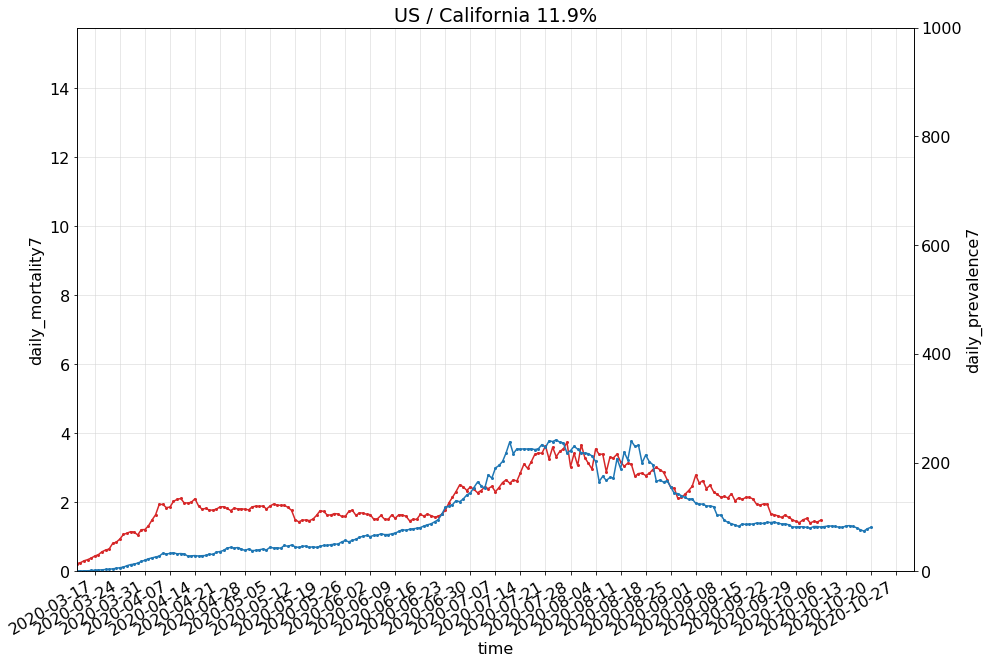

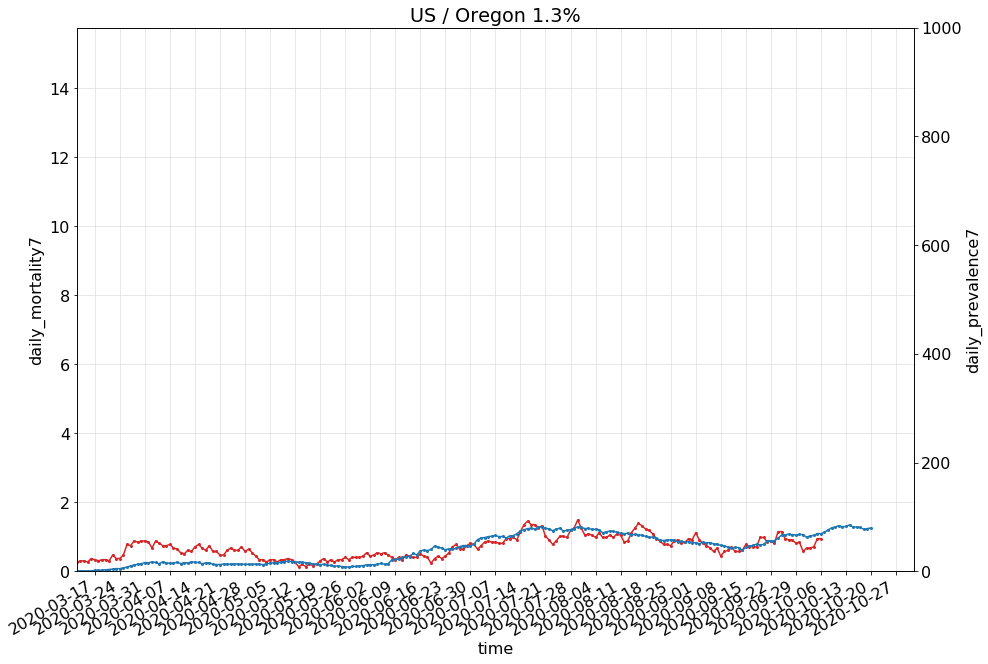

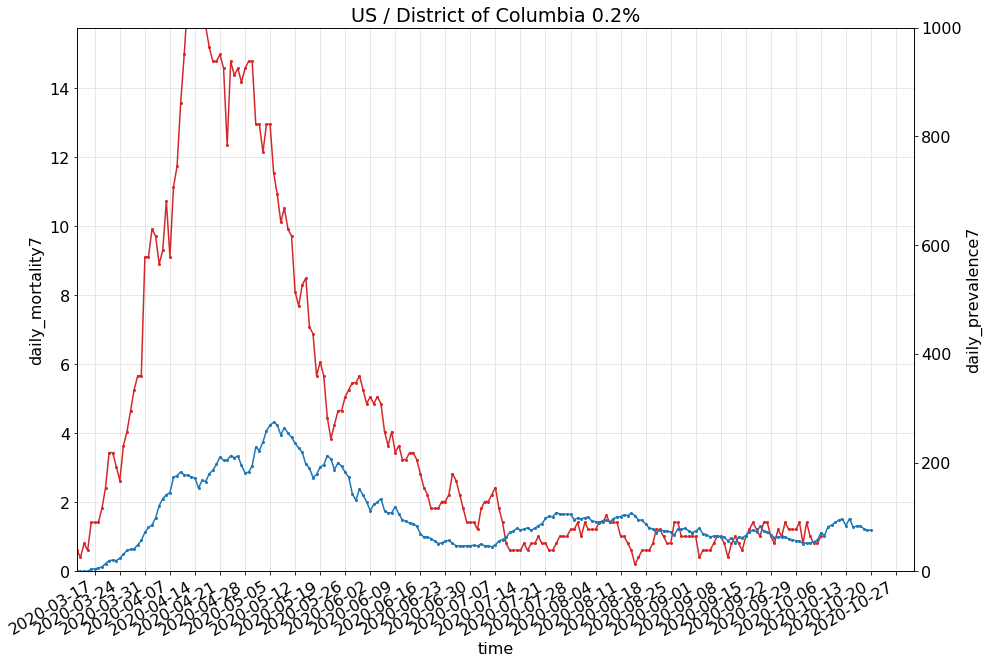

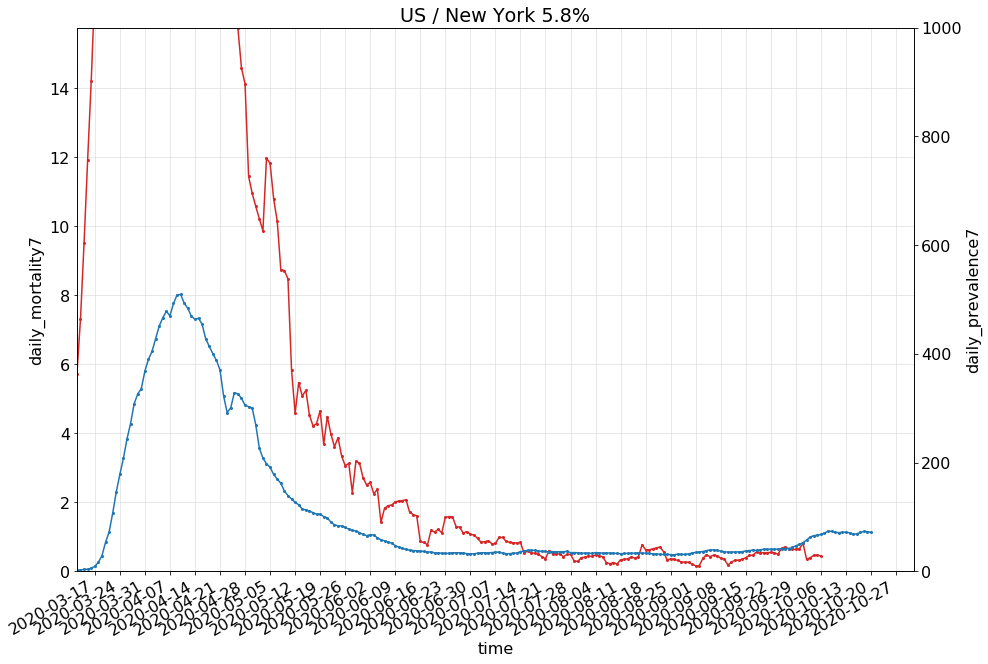

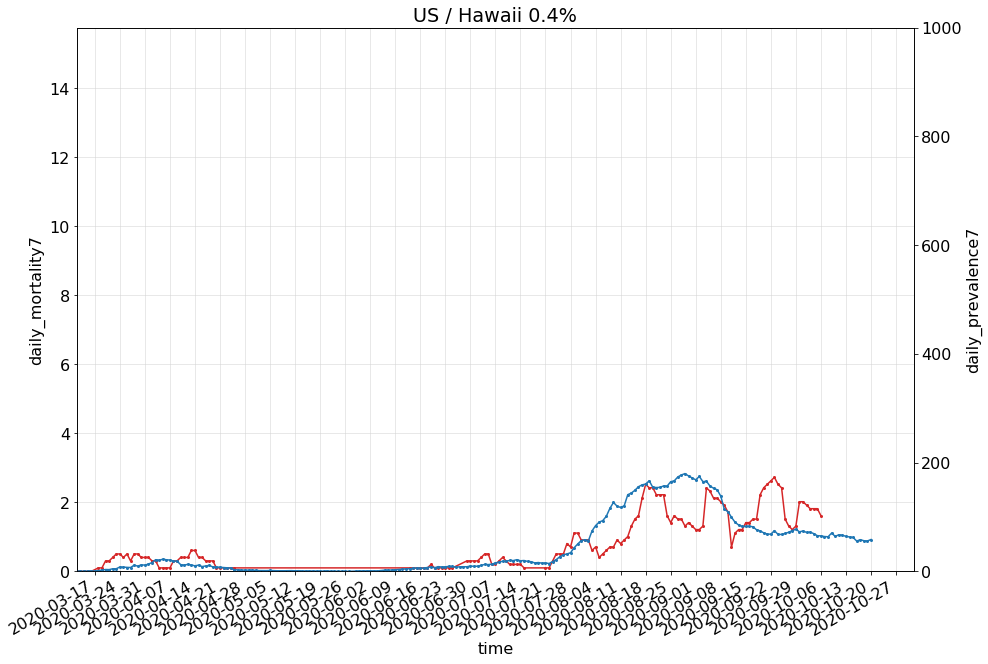

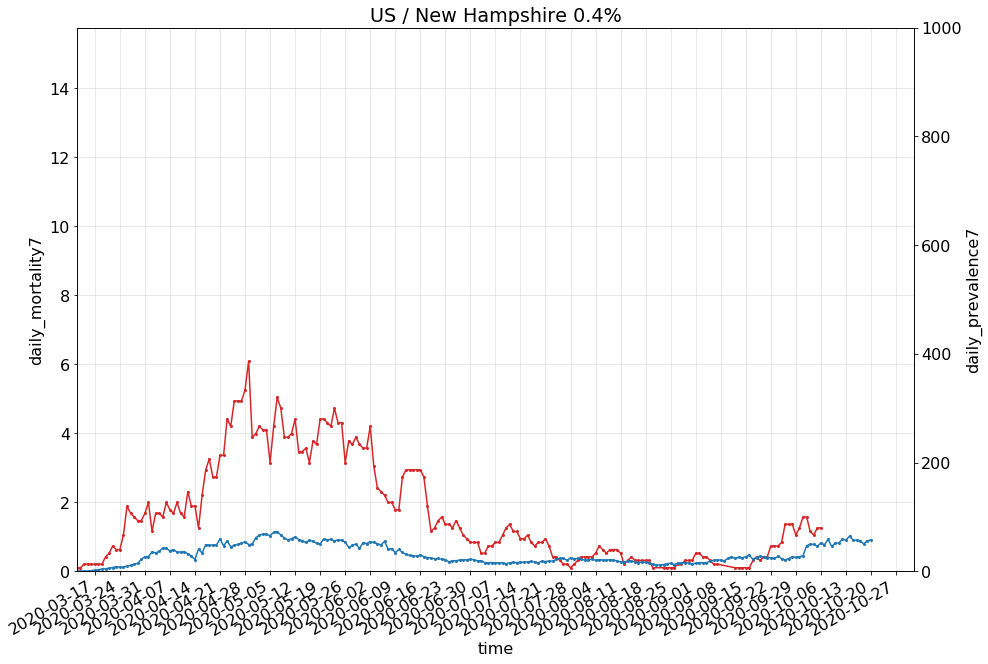

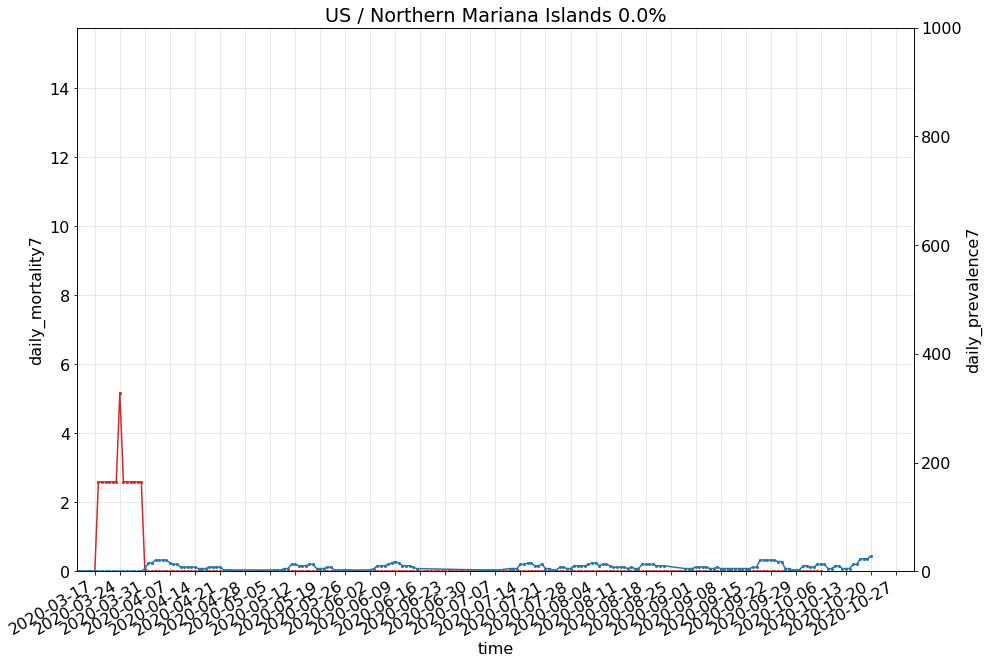

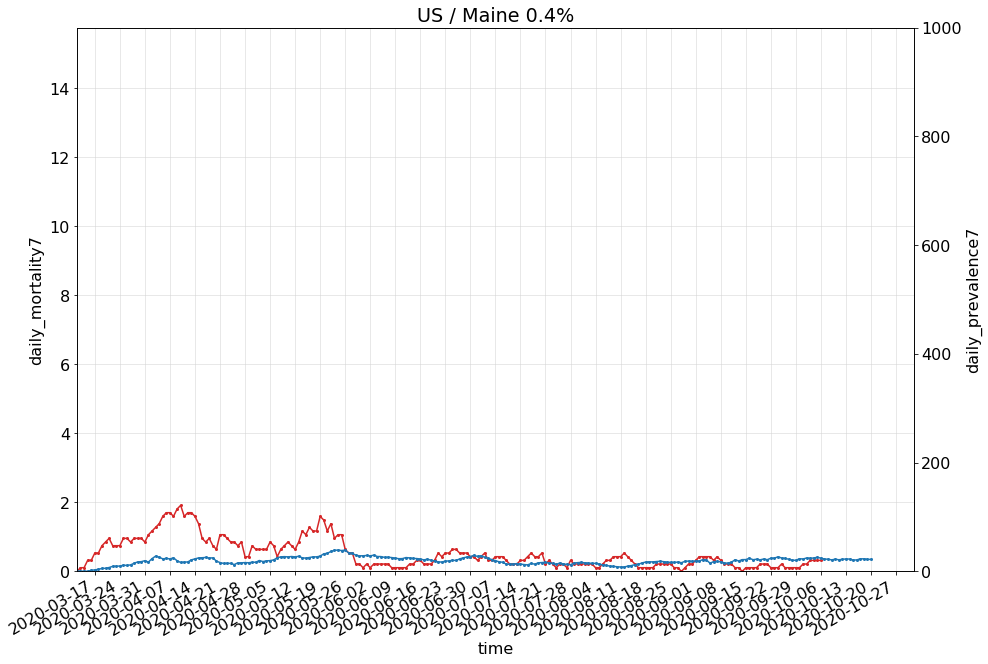

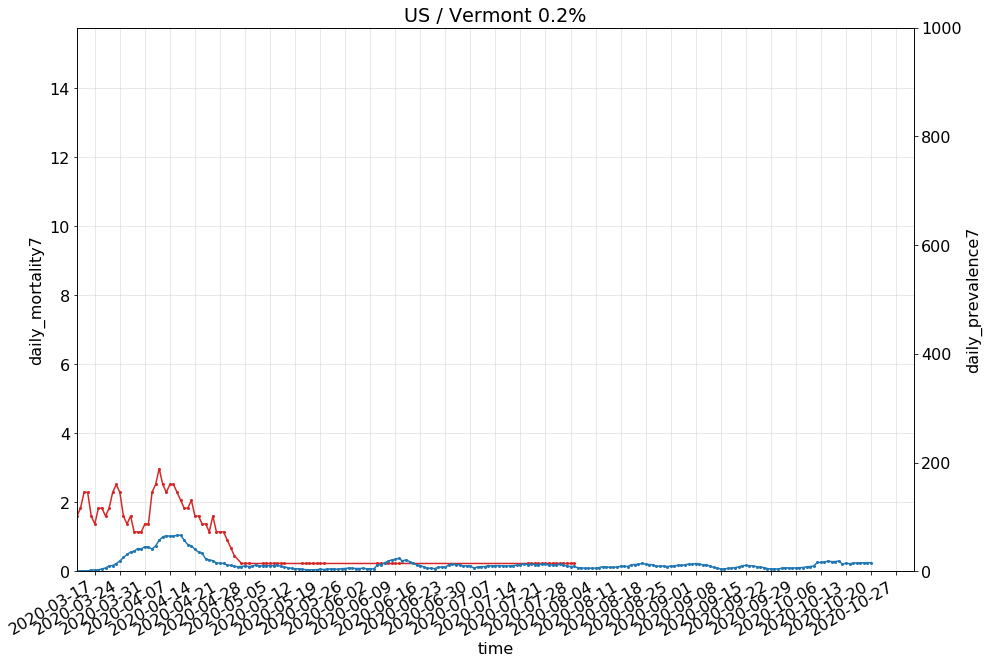

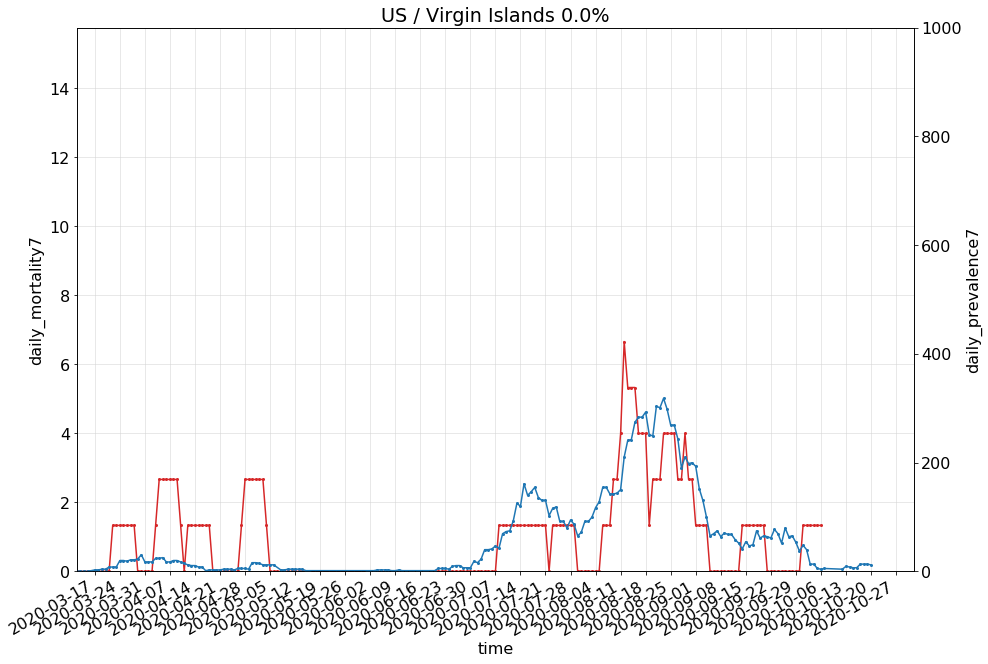

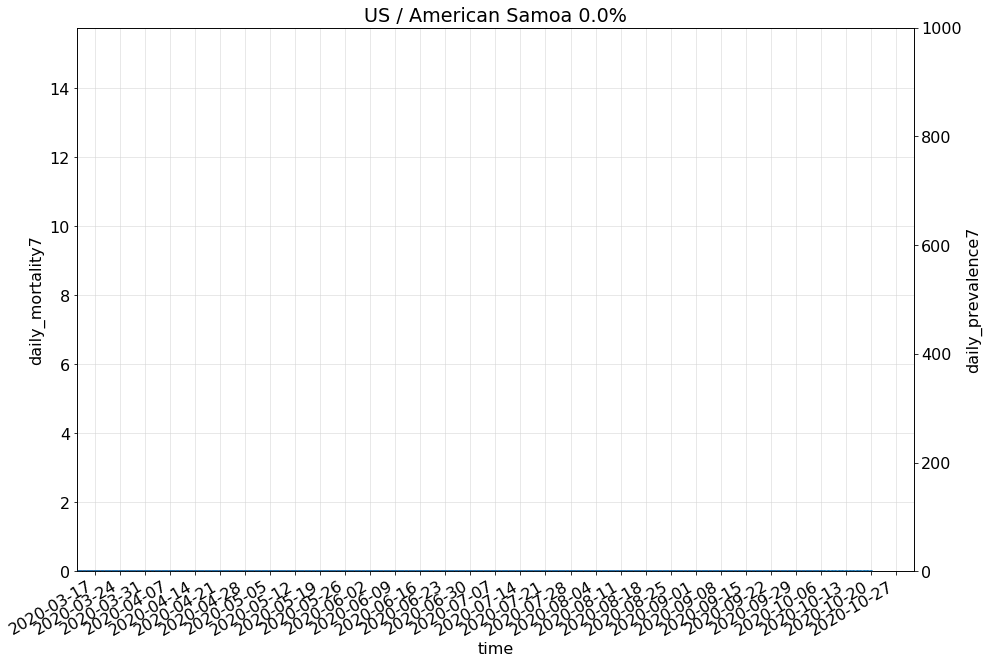

In [114]:
for region in STATES:
    if 'Princess' in region:
        continue
    _, ax1 = plt.subplots(subplot_kw={'xlim': XLIM})

    ax1.set_title(f'COVID-19 {region} - Linear scale')
    ax1.yaxis.tick_right()
    ax1.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax1.xaxis.grid(color='lightgrey', linewidth=0.5)

    ds = ds_states.sel(location=region)

    ax2 = ax1.twinx()
    
    covid19.plot.plot_data(ax1, ds['daily_mortality7'], color=PALETTE_ONE[3], delay=-14)
    covid19.plot.plot_data(ax2, ds['daily_prevalence7'], color=PALETTE_ONE[0])

    ax1.set(ylim=(0, 1000. * 0.01575), title=f"{region} {ds['population'].values / usa['population'].values * 100:.1f}%")
    ax2.set(ylim=(0, 1000.), title=None)